# Оптимизация маркетинговых затрат Яндекс.Афиши   

Для сервиса Яндекс.Афиша необходимо оптимизировать маркетинговые затраты.   

У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 208 года:   
- лог сервера с данными о посещениях сайта Яндекс.Афиши,   
- выгрузка всех заказов за этот период,   
- статистика рекламных расходов.   

В ходе выполнения проекта мы изучим:   
- как люди пользуются продуктом,   
- когда они начинают покупать,   
- сколько денег приносит каждый клиент,   
- когда клиент окупается.

## План оптимизации маркетинговых затрат   <a class="anchor" id="0-bullet">        
    
[1. Откроем файлы с данными и изучим общую информацию](#a)      

[2. Подготовим данные к анализу](#ab)   

- Заменим названия столбцов   
- Преобразуем данные в нужные типы      
- Обработаем пропуски при необходимости    
- Проверим на дубликаты       

[3. Построим отчеты и посчитаем метрики](#abc)      

[3.1. Продукт](#abcd)   

   - Сколько людей пользуются в день, неделю, месяц (DAU, WAU, MAU)   
   - Сколько сессий в день   
   - Сколько длится одна сессия (ASL)   
   - Как часто люди возвращаются (Retention Rate)  
   
[3.2. Продажи](#abcde)   

   - Какой средний чек (Revenue per user)      
   - Когда люди начинают покупать        
   - Сколько раз покупают за период (Number of purchases)  
   - Сколько денег приносят (LTV)   
   
[3.3. Маркетинг](#abcdef)   

   - Сколько денег потратили. Всего / на каждый источник / по времени   
   - Сколько стоило привлечение одного покупателя из каждого источника (CAC)  
   - На сколько окупились расходы (ROI)     
    
[3.4. Посчитаем метрики в разрезе устройств и рекламных источников](#abcdefj)       
    
[3.4.1. Рассчитаем LTV, CAC, ROI для устройств](#abcdefji)   
   - LTV устройств   
   - CAC устройств   
   - ROI устройств    
    
[3.4.2. Рассчитаем LTV, CAC, ROI для рекламных источников](#abcdefjik)      
   - LTV рекламных источников
   - CAC рекламных источников   
   - ROI рекламных источников       
        
[4. Общий вывод](#abcdefjikl)

### 1. Откроем файлы с данными и изучим общую информацию <a name="a"></a>   
[*назад к оглавлению*](#0-bullet)     🚀

### Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### Откроем файлы

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

#### Изучим данные таблицы *visits*

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


#### Описание данных

- Uid — уникальный идентификатор пользователя   
- Device — категория устройства пользователя   
- Start Ts — дата и время начала сессии   
- End Ts — дата и время окончания сессии   
- Source Id — идентификатор рекламного источника, из которого пришел пользователь


Получим общую информацию о данных таблицы   


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Названия столбцов написаны верхним и нижним регистром. Необходимо привести их к единому нижнему регистру.   
Типы данных object столбцов `End Ts` и `Start Ts` не соответствуют требуемым datetime. В таблице 359400 записей, пропусков нет

In [5]:
visits['Device'].value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

Столбец `Device` имеет корректный тип данных object и два уникальных названия 

In [6]:
visits['End Ts'].describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
Name: End Ts, dtype: object

Столбец `End Ts` содержит 224760 уникальных записей о дате и времени окончания сессии. Тип данных некорректный

In [7]:
visits['Source Id'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10])

Столбец `Source Id` содержит записи о девяти рекламных источниках, откуда пришел пользователь. Тип данных корректный

In [8]:
visits['Start Ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
Name: Start Ts, dtype: object

Столбец `Start Ts` содержит 224303 уникальных записи о дате и времени начала сессии. Тип данных некорректный

In [9]:
visits['Uid'].describe()

count    3.594000e+05
mean     9.202557e+18
std      5.298433e+18
min      1.186350e+13
25%      4.613407e+18
50%      9.227413e+18
75%      1.372824e+19
max      1.844668e+19
Name: Uid, dtype: float64

Столбец `Uid` содержит перечень идентификаторов пользователей, тип данных корректный

#### Изучим данные таблицы *orders*

In [10]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


#### Описание данных

- Uid — уникальный id пользователя, который сделал заказ   
- Buy Ts — дата и время заказа   
- Revenue — выручка Яндекс.Афиши с этого заказа

Получим общую информацию о данных таблицы

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Названия столбцов написаны верхним и нижним регистром. Необходимо привести их к единому нижнему регистру.   
Тип данных object столбца `Buy Ts` не соответствует требуемому datetime. В таблице 50415 записей, пропусков нет

In [12]:
orders['Buy Ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
Name: Buy Ts, dtype: object

Столбец `Buy Ts` содержит 45991 уникальную запись о дате и времени заказа. Тип данных некорректный

In [13]:
orders.describe()

,Revenue,Uid
count,50415.000000,5.041500e+04
mean,4.999647,9.098161e+18
std,21.818359,5.285742e+18
min,0.000000,3.135781e+14
25%,1.220000,4.533567e+18
50%,2.500000,9.102274e+18
75%,4.890000,1.368290e+19
max,2633.280000,1.844617e+19


Столбец `Revenue` содержит информацию о выручке с каждого заказа, тип данных корректный. Столбец `Uid` содержит перечень идентификаторов пользователей, тип данных корректный

#### Изучим данные таблицы *costs*

In [14]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


#### Описание данных

- source_id — идентификатор рекламного источника   
- dt — дата   
- costs — затраты на этот рекламный источник в этот день

Получим общую информацию о данных таблицы

In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Тип данных object столбца `dt` не соответствует требуемому datetime. В таблице 2542 записи, пропусков нет

In [16]:
costs['source_id'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  9, 10])

Столбец `source_id` содержит записи о семи рекламных источниках, тип данных корректный

In [17]:
costs['dt'].describe()

count           2542
unique           364
top       2017-11-11
freq               7
Name: dt, dtype: object

Столбец `dt` содержит 364 уникальных записи о дате. Тип данных некорректный

In [18]:
costs['costs'].describe()

count    2542.000000
mean      129.477427
std       156.296628
min         0.540000
25%        21.945000
50%        77.295000
75%       170.065000
max      1788.280000
Name: costs, dtype: float64

Столбец `costs` содержит данные о расходах на рекламу, тип данных корректный

### Вывод

В данных обнаружены следующие несоответствия:      

-  В таблице **visits**   
   - названия столбцов написаны верхним и нижним регистром. Необходимо привести их к единому нижнему регистру   
   - типы данных object столбцов `End Ts` и `Start Ts` не соответствуют требуемым datetime   
- В таблице **orders**   
   - названия столбцов написаны верхним и нижним регистром. Необходимо привести их к единому нижнему регистру   
   - тип данных object столбца `Buy Ts` не соответствует требуемому datetime    
- В таблице **costs***   
   - тип данных object столбца `dt` не соответствует требуемому datetime

### 2. Подготовим данные к анализу <a name="ab"></a>   
[*назад к оглавлению*](#0-bullet)     🚀

Откорректируем названия столбцов и тип данных таблицы **visits**

In [19]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [20]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [21]:
visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

В столбце `start_ts` содержатся даты за период с 01.06.2017 по 31.05.2018

In [22]:
visits['end_ts'].describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: end_ts, dtype: object

В столбце `end_ts` содержатся даты за период с 01.06.2017 по 01.06.2018. Это на один день больше, чем в столбце `start_ts`

Откорректируем названия столбцов и тип данных таблицы **orders**

In [23]:
orders.columns = ['buy_ts', 'revenue', 'uid']

In [24]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [25]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

В столбце `buy_ts` содержатся даты за период с 01.06.2017 по 01.06.2018

Откорректируем тип данных таблицы **costs**

In [26]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [27]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

В столбце `dt` содержатся даты за период с 01.06.2017 по 31.05.2018

Проверим данные таблиц на наличие дубликатов

In [28]:
visits.duplicated().sum()

0

In [29]:
costs.duplicated().sum()

0

In [30]:
orders.duplicated().sum()

0

Дубликатов в таблицах visits, costs, orders нет

### Вывод

Обнаруженные несоответствия устранены:   
- Названия cтолбцов приведены к единому формату   
- Столбцы с датами приведены к типу datetime.    

Данные содержат информацию за период с 01.06.2017 по 31.05.2018 / 01.06.2018

### 3. Построим отчеты и посчитаем метрики <a name="abc"></a>   
[*назад к оглавлению*](#0-bullet)    🚀

### 3.1. Продукт<a name="abcd"></a>     
[*назад к оглавлению*](#0-bullet)    🚀

Посчитаем метрики пользовательской активности: **DAU, WAU, MAU**

Для этого создадим столбцы с днем, неделей, месяцем и годом пользования клиентами Яндекс.Афишей

In [31]:
visits['date'] = visits['start_ts'].dt.date
visits['week'] = visits['start_ts'].dt.week
visits['month'] = visits['start_ts'].dt.month
visits['year'] = visits['start_ts'].dt.year
visits.head()

,device,end_ts,source_id,start_ts,uid,date,week,month,year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,51,12,2017
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,8,2,2018
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,26,7,2017
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,20,5,2018
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,52,12,2017


In [32]:
dau = visits.groupby('date').agg({'uid':'nunique'}).mean().astype('int')
dau

uid    907
dtype: int64

Показатель пользовательской активности за день **DAU** - 907 человек

In [33]:
wau = visits.groupby(['year', 'week']).agg({'uid':'nunique'}).mean().astype('int')
wau

uid    5716
dtype: int64

Показатель пользовательской активности за неделю **WAU** - 5716 человек

In [34]:
mau = visits.groupby(['year', 'month']).agg({'uid':'nunique'}).mean().astype('int')
mau

uid    23228
dtype: int64

Показатель пользовательской активности за месяц **MAU** - 23228 человек

Найдем количество сессий в день и сколько из них приходится на одного пользователя

In [35]:
sessions_per_day = visits.groupby('date').agg({'uid':['count', 'nunique']})
sessions_per_day.columns = ['sessions', 'users']
sessions_per_day['sessions_per_user'] = sessions_per_day['sessions'] / sessions_per_day['users']
sessions_per_day.head()

,sessions,users,sessions_per_user
date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


In [36]:
sessions_per_day['sessions'].mean().astype('int')

987

В среднем за день на Яндекс.Афише открывается 987 сессий 

In [37]:
sessions_per_day['sessions_per_user'].mean()

1.082169644003972

В среднем на одного пользователя ежедневно приходится одна сессия

Найдем среднюю продолжительность сессии **ASL**

In [38]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [39]:
visits['duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: duration, dtype: float64

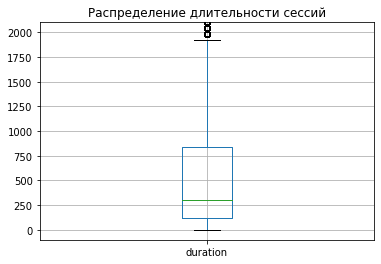

In [40]:
visits.boxplot(column='duration')
plt.title('Распределение длительности сессий')
plt.ylim(-100, 2100);

Медиана длительности сессии - 300 секунд, среднее значение - 643 секунды. Среднее в два раза больше медианы за счет длиного хвоста больших значений, выбросов.

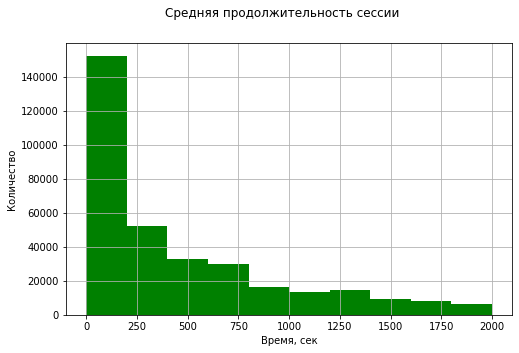

In [41]:
visits['duration'].hist(range=(0,2000), figsize=(8,5), color='green')
plt.suptitle('Средняя продолжительность сессии')
plt.ylabel('Количество')
plt.xlabel('Время, сек');

На гистограмме видно, что продолжительность большинства сессий меньше среднего значения в 643 секунды и даже меньше медианы в 300 секунд. Найдем наиболее часто встречающееся значение, моду - это и будет **ASL** 

In [42]:
asl = visits['duration'].mode()
asl

0    60
dtype: int64

Средняя продолжительность пользовательской сессии **ASL** в Яндекс.Афише составляет 1 минуту

### Retention Rate

Выясним, как часто люди возвращаются на сервис Яндекс.Афиша. Найдем **Retention Rate**

Найдем для каждого пользователя месяц начала его активности

In [43]:
first_visits = visits.groupby('uid')['start_ts'].min()
first_visits.name = 'first_date'

Создадим новый датафрейм **vis** только с нужными нам столбцами

In [44]:
vis = pd.merge(visits, first_visits, on='uid')
vis = vis.drop(['date', 'week', 'month', 'year', 'duration'], axis=1)
vis.head()

,device,end_ts,source_id,start_ts,uid,first_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-09 20:05:00


In [45]:
vis['first_month'] = vis['first_date'].astype('datetime64[M]')
vis['ts_month'] = vis['start_ts'].astype('datetime64[M]')

Найдем продолжительность активности каждого пользователя в месяцах 

In [46]:
vis['lifetime'] = ((vis['ts_month'] - vis['first_month']) / np.timedelta64(1,'M')).round().astype('int')

Сформируем когорты пользователей по месяцам с группировкой по длительности пользования сервисом Яндекс.Афиша

In [47]:
cohorts = vis.groupby(['first_month', 'lifetime']).agg({'uid':'nunique'}).reset_index()

Найдем количество пользователей в их первый месяц использования Яндекс.Афиши

In [48]:
initial_visits = cohorts.query('lifetime == 0')[['first_month', 'uid']]
initial_visits

,first_month,uid
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


In [49]:
initial_visits.columns = ['first_month', 'cohort_users']

In [50]:
cohorts = cohorts.merge(initial_visits, on='first_month')

Рассчитаем **Retention Rate**

In [51]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']
cohorts['first_month'] = cohorts['first_month'].dt.strftime('%Y-%m')

In [52]:
retention = cohorts.pivot_table(index='first_month', columns='lifetime', values='retention', aggfunc='sum')
retention

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_month,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


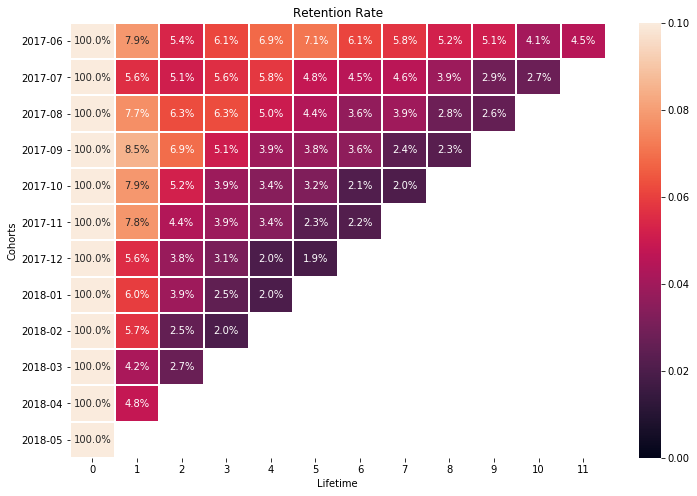

In [53]:
plt.figure(figsize=(12,8))
plt.title('Retention Rate')
sns.heatmap(retention, annot=True, fmt='.1%', linewidths=1, linecolor='white', vmin=0, vmax=0.1)
plt.ylabel('Cohorts')
plt.xlabel('Lifetime');

На тепловой карте таблицы **Retention Rate** видно, что уже на следующем месяце использования сервиса количество пользователей снижается со 100% до 5-8%. В дальнейшем возвращаются на сервис 2-3% пользователей из каждой когорты ежемесячно. Пользователи самой первой когорты наиболее преданные клиенты Яндекс.Афиши по сравнению с пользователями других когорт. У пользователей последних когорт падение пользовательской активности до 2% наблюдается уже на 2-4 месяц lifetime  

###  Вывод    

**Рассчитаны показатели пользовательской активности:**   
**- за день DAU - 907 человек**   
**- за неделю WAU - 5716 человек**  
**- за месяц MAU - 23228 человек.**      

В среднем за день на Яндекс.Афише открывается 987 сессий. **На одного пользователя ежедневно приходится одна сессия.   
Средняя продолжительность пользовательской сессии ASL в Яндекс.Афише составляет 1 минуту.**   

При расчете **Retention Rate** обнаружилось, что уже на следующем месяце использования сервиса количество пользователей **снижается до 5-8%**. В дальнейшем  **ежемесячно возвращаются на сервис 2-3% пользователей** из каждой когорты. Пользователи самой первой когорты (июнь 2017 г.) наиболее преданные клиенты Яндекс.Афиши по сравнению с пользователями других когорт. У пользователей когорт 2018 г. падение пользовательской активности до 2% наблюдается уже на 2-4 месяц lifetime.   

### 3.2. Продажи <a name="abcde"></a>        
[*назад к оглавлению*](#0-bullet)    🚀

### Revenue per user

Посмотрим, чему равен средний чек в каждой когорте покупателей и как он меняется в течение lifetime когорты

In [54]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Найдем для каждого пользователя месяц его первой покупки

In [55]:
first_buy_date = orders.groupby('uid')['buy_ts'].min()
first_buy_date.name = 'first_buy_date'

In [56]:
orders = orders.merge(first_buy_date, on='uid')
orders['first_buy_month'] = orders['first_buy_date'].astype('datetime64[M]')
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,first_buy_date,first_buy_month,buy_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Найдем продолжительность активности каждого пользователя в месяцах

In [57]:
orders['lifetime'] = ((orders['buy_month'] - orders['first_buy_month']) / np.timedelta64(1,'M')).round().astype('int')

Сформируем когорты пользователей по месяцам с группировкой по длительности их покупательской активности

In [58]:
cohorts = orders.groupby(['first_buy_month', 'lifetime']).agg({'revenue':'sum', 'uid':'nunique'}).reset_index()

Найдем средний чек покупателя **Revenue per user**

In [59]:
cohorts['revenue_per_user'] = cohorts['revenue'] / cohorts['uid']
cohorts['first_buy_month'] = cohorts['first_buy_month'].dt.strftime('%Y-%m')

In [60]:
revenue_per_user = cohorts.pivot_table(index='first_buy_month', columns='lifetime', values='revenue_per_user')
revenue_per_user

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,4.724414,16.095410,17.706800,35.764815,23.506591,22.207761,31.011935,25.033191,19.295690,27.233556,25.681333,9.804151
2017-07,6.010218,12.396346,21.035965,10.786094,6.938163,7.896842,6.421111,6.992821,7.382143,12.861818,11.513846,NaN
2017-08,5.276518,11.148793,11.851321,12.182955,16.921250,12.139063,9.620333,12.610455,21.070000,8.307419,NaN,NaN
2017-09,5.644529,22.188385,13.445200,138.669189,19.881538,26.095000,27.437121,16.961351,11.044651,NaN,NaN,NaN
2017-10,5.003733,11.287427,6.753252,7.413152,7.072796,7.255139,6.573214,7.479701,NaN,NaN,NaN,NaN
2017-11,5.154683,7.339054,6.786583,12.510660,7.457284,4.580833,7.564839,NaN,NaN,NaN,NaN,NaN
2017-12,4.738191,7.816575,39.366019,48.135052,27.431400,23.518413,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.135636,8.721228,12.365542,11.199767,4.699556,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.156987,8.610000,4.942414,6.941026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


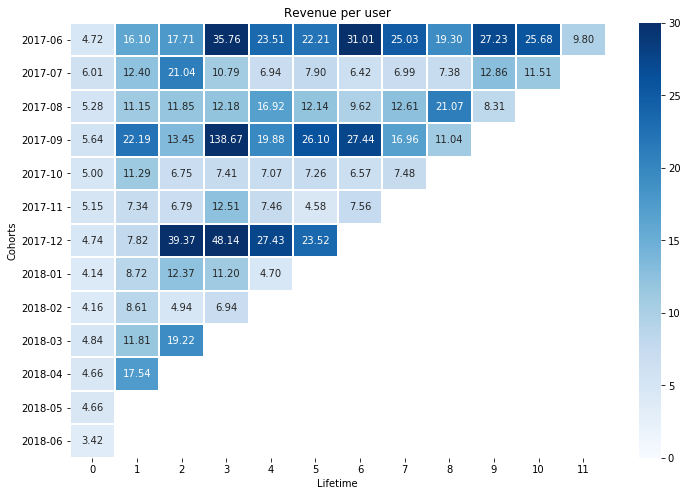

In [61]:
plt.figure(figsize=(12,8))
plt.title('Revenue per user')
sns.heatmap(revenue_per_user, annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0, vmax=30, cmap='Blues')
plt.ylabel('Cohorts')
plt.xlabel('Lifetime');

Визуально легко определить, что величина среднего чека зависит от когорты.   
В когортах июня, сентября и декабря 2017г. средний чек порядка 20-30 руб. Причем сентябрьская когорта на 4-й месяц жизни установила рекорд по максимуму, средний чек составил 139 руб. О самых молодых когортах марта и апреля 2018г. пока ничего определенного сказать нельзя ,т.к. недостаточно информации. В остальных когортах величина среднего чека варьируется в пределах 7-12 руб.     
Наблюдается общая тенденция роста среднего чека со второго месяца жизни когорты вплоть до четвертого месяца. Может сервис Яндекс.Афиши предлагает своим постоянным клиентам какие-то преференции или бонусы, и пользователям это нравится   

In [62]:
avg_revenue = cohorts.groupby('first_buy_month').agg({'revenue':'sum', 'uid':'sum'})
avg_revenue['avg_revenue_by_cohorts'] =  avg_revenue['revenue'] / avg_revenue['uid']
avg_revenue['avg_revenue_by_cohorts'].round(2).sort_values(ascending=False)

first_buy_month
2017-09    11.02
2017-06     9.06
2017-12     6.92
2017-07     6.87
2017-08     6.74
2017-11     5.53
2017-10     5.47
2018-03     5.24
2018-04     5.04
2018-05     4.66
2018-01     4.56
2018-02     4.33
2018-06     3.42
Name: avg_revenue_by_cohorts, dtype: float64

Величина среднего чека у разных когорт разная.   
Лидеры - когорты 2017 года: сентябрь - 11 рублей и июнь - 9 рублей.   
Аутсайдеры - когорты 2018 года: июнь и февраль. Средний чек не превышает 4,5 рублей

In [63]:
avg_revenue['avg_revenue_by_cohorts'].mean().round(2)

6.06

Средний чек пользователя Яндекс.Афиши составляет 6 рублей

### Время от посещения сервиса до первой покупки

Отфильтруем информацию по самым первым посещениям пользователей сервиса

In [64]:
first_vis = vis.query('start_ts == first_date')

Создадим датафрейм **revenue** для дальнейшего анализа 

In [65]:
revenue = pd.merge(first_vis[['device', 'source_id', 'uid', 'first_date']],\
                  orders[['buy_ts', 'revenue', 'uid', 'first_buy_date']], on='uid')

In [66]:
revenue.head()

,device,source_id,uid,first_date,buy_ts,revenue,first_buy_date
0,desktop,4,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00
1,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00
2,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00
3,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00
4,desktop,2,8056418121947262981,2017-06-04 14:17:00,2017-06-25 08:54:00,3.67,2017-06-25 08:54:00


Узнаем, когда пользователи сервиса начинают покупать

In [67]:
revenue['time_before_buying'] = (revenue['first_buy_date'] - revenue['first_date']).dt.total_seconds() / 60

In [68]:
revenue['time_before_buying'].describe()

count     50415.000000
mean      25368.990618
std       66910.801873
min           0.000000
25%           4.000000
50%          22.000000
75%        6231.000000
max      523144.000000
Name: time_before_buying, dtype: float64

Исходя из описания статистических показателей **25% пользователей Яндекс.Афиши совершают свою первую покупку в течение 4 минут после регистрации**.   
**Половина пользователей Яндекс.Афиши совершает свою первую покупку в течение 22 минут после регистрации**.       
У еще 25% пользователей это время занимает чуть больше 4-х суток            

Посмотрим на распределение времени между регистрацией и покупкой на диаграмме размаха и гистограмме

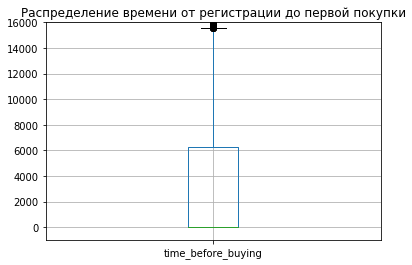

In [69]:
revenue.boxplot(column='time_before_buying')
plt.ylim(-1000, 16000)
plt.title('Распределение времени от регистрации до первой покупки');

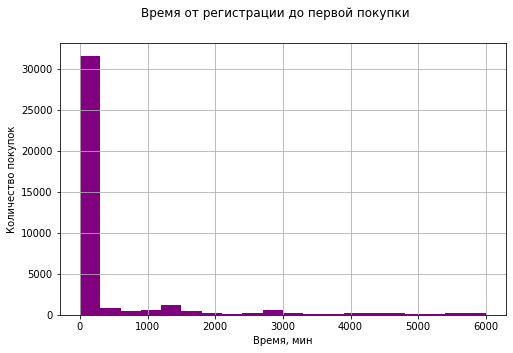

In [70]:
revenue['time_before_buying'].hist(range=(0,6000), figsize=(8,5), bins=20, color='purple')
plt.suptitle('Время от регистрации до первой покупки')
plt.ylabel('Количество покупок')
plt.xlabel('Время, мин');

Нормальное распределение времени находится в пределах от 0 минут до 16000 минут (11 суток). На диаграмме размаха видно, что медиана в 22 минуты находится на нулевом значении. Значит большинство покупок совершается рядом с нулевым показателем. Найдем наиболее часто встречающееся значение, моду

In [71]:
revenue['time_before_buying'].mode()

0    0.0
dtype: float64

Мода равна нулю. Посмотрим на временной промежуток от 0 до 20 минут вблизи

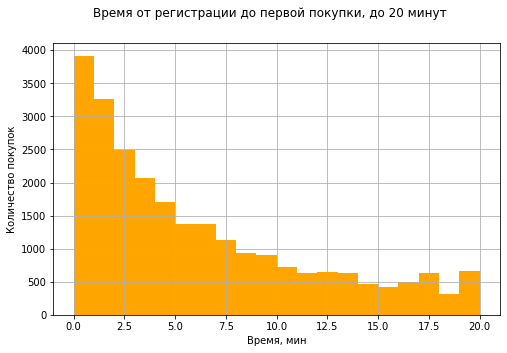

In [72]:
revenue['time_before_buying'].hist(range=(0,20), figsize=(8,5), bins=20, color='orange')
plt.suptitle('Время от регистрации до первой покупки, до 20 минут')
plt.ylabel('Количество покупок')
plt.xlabel('Время, мин');

In [73]:
len(revenue.query('time_before_buying == 0')) / len(revenue) * 100

7.763562431815927

**Почти 8% пользователей сразу после регистрации оплачивают покупку на Яндекс.Афише**.    
По-видимому, пользователи, с момента регистрации которых и до первой покупки проходит несколько часов, дней, а иногда и месяцев, после регистрации на сервисе меняют свое решение пойти в кино или театр. А по прошествии какого-то времени приобретают билеты на Яндекс.Афише, используя уже имеющиеся логин и пароль

### Number of purchases 

Посмотрим, сколько покупок совершают пользователи ежемесячно

In [74]:
orders['first_buy_month'] = orders['first_buy_month'].dt.strftime('%Y-%m')

Найдем количество покупок по каждой когорте и проанализируем его изменение с течением времени

In [75]:
purchases = orders.pivot_table(index='first_buy_month', columns='lifetime', values='uid', aggfunc='count')
purchases

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,2354.0,177.0,174.0,226.0,292.0,218.0,276.0,174.0,212.0,153.0,96.0,86.0
2017-07,2186.0,100.0,120.0,104.0,72.0,82.0,61.0,50.0,58.0,24.0,53.0,NaN
2017-08,1533.0,108.0,100.0,81.0,85.0,62.0,49.0,78.0,46.0,46.0,NaN,NaN
2017-09,2933.0,219.0,161.0,164.0,67.0,109.0,108.0,56.0,61.0,NaN,NaN,NaN
2017-10,4964.0,314.0,162.0,122.0,129.0,103.0,86.0,125.0,NaN,NaN,NaN,NaN
2017-11,4813.0,397.0,182.0,211.0,136.0,59.0,102.0,NaN,NaN,NaN,NaN,NaN
2017-12,5052.0,270.0,202.0,179.0,86.0,105.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,3783.0,224.0,159.0,64.0,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4095.0,222.0,83.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


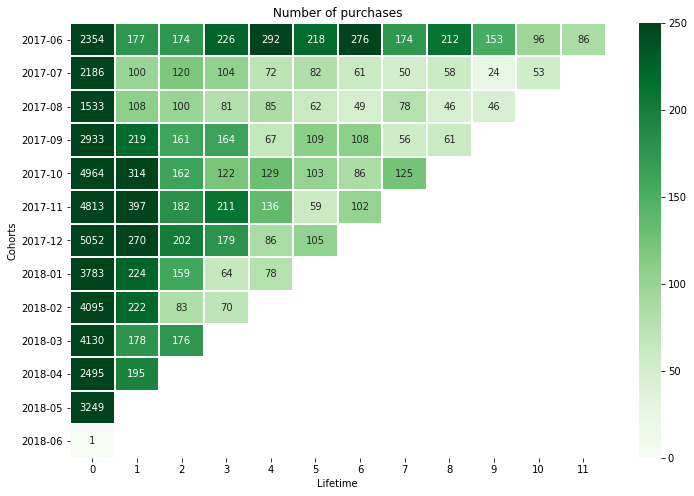

In [76]:
plt.figure(figsize=(12,8))
plt.title('Number of purchases')
sns.heatmap(purchases, annot=True, fmt='.0f', linewidths=1, linecolor='white', vmin=0, vmax=250, cmap='Greens')
plt.ylabel('Cohorts')
plt.xlabel('Lifetime');

В первый месяц существования каждой когорты пользователи совершают максимальное количество покупок - от 1533 до 5052.    
На второй месяц lifetime объем покупок во всех когортах падает почти в десять раз: от 100 до 400 покупок.    
С течением времени наблюдается угасание пользовательской активности.  
Наиболее активной в течение всей жизни остается когорта июня 2017г


In [77]:
int(purchases.mean().mean())

372

Количество покупок, совершаемых пользователями ежемесячно, в среднем составляет 372 покупки

In [78]:
purchases.loc['2017-06':'2017-12', '0':'5'].mean().mean().round()

696.0

Среднее количество покупок, совершаемых пользователями ежемесячно, за первые полгода жизни когорты, почти в два раза больше - 700 покупок. Такое увеличение объясняется тем, что первый месяц жизни когорты является месяцем максимальной покупательской активности пользователей. С течением свремени происходит затухание величины среднего количества покупок

In [79]:
purchases.mean(axis=1).round().sort_values(ascending=False)

first_buy_month
2018-05    3249.0
2018-03    1495.0
2018-04    1345.0
2018-02    1118.0
2017-12     982.0
2018-01     862.0
2017-11     843.0
2017-10     751.0
2017-09     431.0
2017-06     370.0
2017-07     265.0
2017-08     219.0
2018-06       1.0
dtype: float64

Лидеры покупательской активности - когорты 2018 г. Это связано с тем, что большой объем покупок в первом месяце доминирует над остальными показателями небольшого количества месяцев в молодых когортах. На тепловой карте видно, что настоящими лидерами, приносящими регулярный доход сервису в течение длительного периода, являются когорты июня и ноября 2017г

Посмотрим, сколько покупок делает средний покупатель за месяц

In [80]:
users = orders.pivot_table(index='first_buy_month', columns='lifetime', values='uid', aggfunc='nunique')
purchases_by_user = purchases / users
purchases_by_user

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,1.163618,2.901639,3.480000,4.185185,3.318182,3.253731,4.451613,3.702128,3.655172,3.400000,2.133333,1.622642
2017-07,1.136765,1.923077,2.105263,1.625000,1.469388,2.157895,1.694444,1.282051,1.380952,1.090909,2.038462,NaN
2017-08,1.118978,1.862069,1.886792,1.840909,2.125000,1.937500,1.633333,1.772727,2.421053,1.483871,NaN,NaN
2017-09,1.136381,1.684615,1.610000,2.216216,1.288462,1.703125,1.636364,1.513514,1.418605,NaN,NaN,NaN
2017-10,1.143779,1.524272,1.317073,1.326087,1.387097,1.430556,1.535714,1.865672,NaN,NaN,NaN,NaN
2017-11,1.179368,1.788288,1.516667,1.990566,1.679012,1.229167,1.645161,NaN,NaN,NaN,NaN,NaN
2017-12,1.152635,1.849315,1.961165,1.845361,1.720000,1.666667,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.121554,1.964912,1.915663,1.488372,1.733333,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.121611,1.881356,1.431034,1.794872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
purchases_by_user.loc['2017-06':'2017-12', '0':'5'].sum(axis=1).round()

first_buy_month
2017-06    18.0
2017-07    10.0
2017-08    11.0
2017-09    10.0
2017-10     8.0
2017-11     9.0
2017-12    10.0
dtype: float64

Количество покупок, совершенных одним пользователем в разных когортах в течение полугода - от 18 до 8

In [82]:
purchases_by_user.loc['2017-06':'2017-12', '0':'5'].sum(axis=1).mean().round()

11.0

Среднее количество покупок, совершаемых пользователем за полгода - 11 шт. 

###  LTV 

Рассчитаем **LTV** пользователей Яндекс.Афиши

In [83]:
orders.head()

,buy_ts,revenue,uid,first_buy_date,first_buy_month,buy_month,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06,2017-06-01,0


Найдем количество новых покупателей в каждом месяце

In [84]:
buyers = orders.groupby('first_buy_month').agg({'uid':'nunique'}).reset_index()
buyers.columns = ['first_buy_month', 'number_of_buyers']

Посчитаем выручку за каждый месяц и добавим данные о новых покупателях

In [85]:
cohorts = orders.groupby(['first_buy_month', 'buy_month']).agg({'revenue':'sum'}).reset_index()
cohorts = cohorts.merge(buyers, on='first_buy_month')

Отобразим lifetime когорт 

In [86]:
cohorts['first_buy_month'] = pd.to_datetime(cohorts['first_buy_month'])

In [87]:
cohorts['lifetime'] = ((cohorts['buy_month'] - cohorts['first_buy_month']) / np.timedelta64(1,'M')).round().astype('int')

Построим сводную таблицу с показателем LTV за каждый месяц

In [88]:
cohorts['ltv'] = cohorts['revenue'] / cohorts['number_of_buyers']
cohorts['first_buy_month'] = cohorts['first_buy_month'].dt.strftime('%Y-%m')
ltv = cohorts.pivot_table(index='first_buy_month', columns='lifetime', values='ltv', aggfunc='mean').round(2)
ltv

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,4.72,0.49,0.44,0.95,1.02,0.74,0.95,0.58,0.55,0.61,0.57,0.26
2017-07,6.01,0.34,0.62,0.36,0.18,0.16,0.12,0.14,0.16,0.15,0.16,NaN
2017-08,5.28,0.47,0.46,0.39,0.49,0.28,0.21,0.41,0.29,0.19,NaN,NaN
2017-09,5.64,1.12,0.52,3.98,0.40,0.65,0.70,0.24,0.18,NaN,NaN,NaN
2017-10,5.00,0.54,0.19,0.16,0.15,0.12,0.08,0.12,NaN,NaN,NaN,NaN
2017-11,5.15,0.40,0.20,0.32,0.15,0.05,0.11,NaN,NaN,NaN,NaN,NaN
2017-12,4.74,0.26,0.93,1.07,0.31,0.34,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.14,0.29,0.30,0.14,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.16,0.28,0.08,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


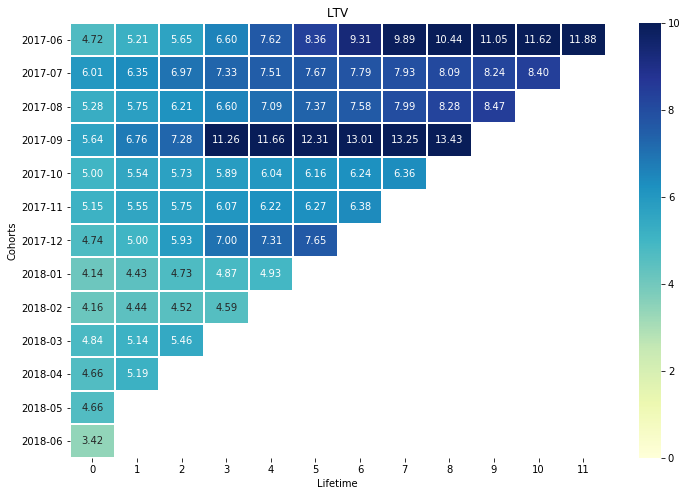

In [89]:
plt.figure(figsize=(12,8))
plt.title('LTV')
sns.heatmap(ltv.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0, vmax=10, cmap='YlGnBu')
plt.ylabel('Cohorts')
plt.xlabel('Lifetime');

Больше всего денег пользователи приносят в первый месяц lifetime когорты. По доходности тройку лидеров занимают уже знакомые нам по **Revenue per user** когорты: июнь 2017, сентябрь 2017 и декабрь 2017.    
С течением времени происходит затухание показателя **LTV** за месяц. Однако с течением времение показатель **LTV** все равно растет, так как это накопительная метрика

In [90]:
ltv[0].mean().round(2)

4.8

**LTV** пользователя **за первый месяц** lifetime составил **4,8 рублей**

Посчитаем, сколько денег приносит в среднем каждый покупатель Яндекс.Афиши за различные периоды пользования сервисом

In [91]:
ltv.loc['2017-06':'2017-12', '0':'5'].sum().mean().round(2)

9.3

**LTV** пользователя **за первые полгода** жизни когорты составляет **9,3 рубля**

In [92]:
ltv.loc['2017-06'].sum()

11.88

**LTV** пользователя когорты июня 2017г. **за год** lifetime составляет **почти 12 рублей**

### Вывод   

**Средний чек Revenue per user пользователя Яндекс.Афиши составляет 6 рублей. Величина среднего чека у разных когорт разная**.   
Лидеры - когорты 2017 года: сентябрь - 11 рублей и июнь - 9 рублей.
Аутсайдеры - когорты 2018 года: июнь и февраль. Средний чек не превышает 4,5 рублей. Сентябрьская когорта на 4-й месяц жизни установила рекорд по максимуму, средний чек составил 139 руб. 
Наблюдается общая тенденция роста среднего чека со второго месяца жизни когорты вплоть до четвертого месяца. Вероятно сервис Яндекс.Афиши предлагает своим постоянным клиентам какие-то преференции или бонусы, и пользователи этим с удовольствием пользуются.      

Исходя из описания статистических показателей **50% пользователей Яндекс.Афиши совершает свою первую покупку в течение 22 минут после регистрации, в том числе 25% пользователей совершают свою первую покупку в течение 4 минут после регистрации, в том числе 8% пользователей сразу после регистрации оплачивают покупку.** У еще 25% пользователей это время занимает чуть больше 4-х суток. По-видимому, пользователи, с момента регистрации которых и до первой покупки проходит несколько часов, дней, а иногда и месяцев, после регистрации на сервисе меняют свое решение пойти в кино или театр. А по прошествии какого-то времени приобретают билеты на Яндекс.Афише, используя уже имеющиеся логин и пароль.         

**Количество покупок, совершенных одним пользователем в разных когортах в течение полугода - от 18 до 8. Среднее количество покупок, совершаемых пользователем за полгода - 11 шт.**   
В первый месяц существования каждой когорты пользователи совершают максимальное количество покупок Number of purchases - от 1533 до 5052. Количество покупок, совершаемых пользователями ежемесячно, в среднем составляет **372 покупки** Среднее количество покупок, совершаемых пользователями ежемесячно, за первые полгода жизни когорты, почти в два раза больше - **700 покупок**. Такое увеличение объясняется тем, что первый месяц жизни когорты является месяцем максимальной покупательской активности пользователей. С течением свремени происходит затухание величины среднего количества покупок. **Изменение среднего количества покупок с течением времени очень динамичное: от 3200 покупок в первый месяц lifetime когорт до 70-80 покупок в конце года**. С течением времени наблюдается угасание пользовательской активности. Наиболее активной в течение всей жизни остается когорта покупателей июня 2017г.         

В результате расчета **LTV** выяснилось, что больше всего денег пользователи приносят в первый месяц lifetime когорты. По доходности тройку лидеров занимают уже знакомые нам по Revenue per user когорты: июнь 2017, сентябрь 2017 и декабрь 2017. **LTV пользователя за первые полгода жизни когорты составляет 9,3 рубля**. С течением времени происходит затухание показателя LTV в месяц. 

### 3.3. Маркетинг <a name="abcdef"></a>        
[*назад к оглавлению*](#0-bullet)    🚀

### Рекламные расходы в разрезе источников и по времени 

Посмотрим, сколько денег было потрачено на рекламу сервиса Яндекс.Афиши

In [93]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Таблица содержит данные о рекламных расходах за год: с 01.06.2017 по 31.05.2018

In [94]:
costs['costs'].sum()

329131.62

Всего за год на рекламу было потрачено почти 330 тысяч рублей

Посмотрим на распределение бюджета по рекламным источникам

In [95]:
costs.pivot_table(index='source_id', values='costs', aggfunc='sum').sort_values(by='costs', ascending=False)

,costs
source_id,
3,141321.63
4,61073.60
5,51757.10
2,42806.04
1,20833.27
10,5822.49
9,5517.49


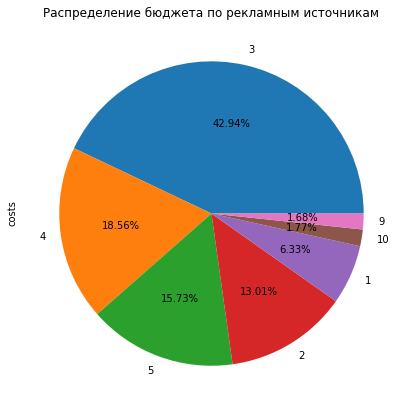

In [96]:
(costs.pivot_table(index='source_id', values='costs', aggfunc='sum').sort_values(by='costs', ascending=False)
 .plot(kind='pie', y='costs', autopct='%1.2f%%', figsize=(7,7), legend=None, 
       title='Распределение бюджета по рекламным источникам'));

Реклама услуг сервиса через 3-й источник наиболее затратная: 141300 руб за год и составляет 43% расходов.    
На втором месте по затратам 4-й источник: 61000 рублей в год и 18,5% от всех расходов.   
Самые дешевые рекламные источники 10-й и 9-й: на каждый из них приходится не более 6000 руб ежегодного бюджета.   
Остальные рекламные источники обходятся от 20000 до 60000 руб ежегодно 

Проанализируем, как изменялся рекламный бюджет в течение года 

In [97]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs.pivot_table(columns='costs_month', values='costs', aggfunc='sum' )

costs_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
costs,18015.0,18240.59,14790.54,24368.91,36322.88,37907.88,38315.35,33518.52,32723.03,30415.27,22289.38,22224.27


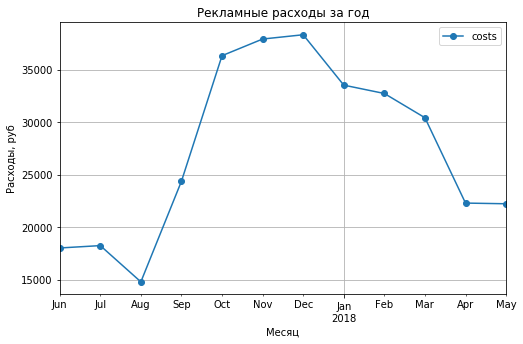

In [98]:
(costs.pivot_table(index='costs_month', values='costs', aggfunc='sum' )
 .plot(title='Рекламные расходы за год',style='o-', figsize=(8,5), grid=True))
plt.xlabel('Месяц')
plt.ylabel('Расходы, руб');

Если посмотреть на рекламные расходы за год с разбивкой по месяцам, то самым затратным месяцем стал декабрь 2017г. - 38300 руб. По-видимому это связано с новогодними каникулами: чем больше рекламы, тем больше клиентов решат пойти в кино или театр путем покупки билетов через Яндекс.Афишу.   
Самые дорогие в плане рекламного бюджета месяцы: с октября 2017 по март 2018: расходы на рекламу ежемесячно более 30000 руб. Скорее всего, это вызвано сезонностью работы театров, концертных залов и тем, что пользователи в основном работают и свободное время тратят на культурно-массовые развлечения. Весной интерес посетителей кино-концертных залов начинает переключаться на активный отдых, и расходы на рекламу тоже начинают снижаться.         
Летом рекламный бюджет заметно снижается и не превышает 19000 руб. Это объясняется тем, что многие уезжают или за город, или в отпуск. Вообщем пользователи гораздо меньше свободного времени летом проводят в кино или театрах  

###  CAC 

Найдем стоимость привлечения одного покупателя **CAC** в каждой когорте

In [99]:
monthly_costs = costs.pivot_table(index='costs_month', values='costs', aggfunc='sum')
cohorts['first_buy_month'] = pd.to_datetime(cohorts['first_buy_month'])

In [100]:
cac_cohort = cohorts.merge(monthly_costs, left_on='first_buy_month', right_on='costs_month')
cac_cohort['cac'] = cac_cohort['costs'] / cac_cohort['number_of_buyers']
cac_cohort.head()

,first_buy_month,buy_month,revenue,number_of_buyers,lifetime,ltv,costs,cac
0,2017-06-01,2017-06-01,9557.49,2023,0,4.724414,18015.0,8.905091
1,2017-06-01,2017-07-01,981.82,2023,1,0.485329,18015.0,8.905091
2,2017-06-01,2017-08-01,885.34,2023,2,0.437637,18015.0,8.905091
3,2017-06-01,2017-09-01,1931.30,2023,3,0.954671,18015.0,8.905091
4,2017-06-01,2017-10-01,2068.58,2023,4,1.022531,18015.0,8.905091


In [101]:
cac_cohort.groupby('first_buy_month').agg({'cac':'mean'}).round(2)

,cac
first_buy_month,
2017-06-01,8.91
2017-07-01,9.49
2017-08-01,10.80
2017-09-01,9.44
2017-10-01,8.37
2017-11-01,9.29
2017-12-01,8.74
2018-01-01,9.94
2018-02-01,8.96


In [102]:
cac_cohort.groupby('first_buy_month').agg({'cac':'mean'})['cac'].mean().round(2)

9.15

В среднем расходы на привлечение одного пользователя когорты **CAC** составляют **9,15 рублей**.   
Самый большой **CAC** у пользователей когорты августа 2017г. - почти 11 рублей, самый маленький **CAC** у пользователей когорты мая 2018 г. - 7,5 рублей 

Выясним, сколько стоило привлечение одного покупателя **CAC** из каждого рекламного источника

In [103]:
source = revenue.groupby('source_id').agg({'uid':'nunique'})
source.columns = ['buyers']
costs_source = costs.groupby('source_id').agg({'costs':'sum'})

In [104]:
cac_source = source.merge(costs_source, on='source_id')

In [105]:
cac_source['cac'] =  (cac_source['costs'] / cac_source['buyers']).round(2)
cac_source

,buyers,costs,cac
source_id,,,
1,2899,20833.27,7.19
2,3506,42806.04,12.21
3,10473,141321.63,13.49
4,10296,61073.60,5.93
5,6931,51757.10,7.47
9,1088,5517.49,5.07
10,1329,5822.49,4.38


In [106]:
cac_source['cac'].mean().round(2)

7.96

В среднем расходы на привлечение одного покупателя через рекламный источник **CAC** составляют **8 рублей**.   
Дороже всего обходятся покупатели, привлекаемые из 3-го рекламного источника: **CAC** 13,5 рублей.      
Меньше всего тратится рекламного бюджета на покупателей из 10-го рекламного источника: **CAC** 4,5 рубля

###  ROI

Узнаем, на сколько окупились расходы. Вычтем из полученной суммы прибыли затраты на рекламу  

In [107]:
round(orders['revenue'].sum() - costs['costs'].sum())

-77074

In [108]:
(orders['revenue'].sum() - costs['costs'].sum()) / costs['costs'].sum() * 100

-23.417506953601112

Получилось, что реклама не окупается. Расходы превышают доходы на 23%. Сервису Яндекс.Афиша еще надо заработать 77 тысяч рублей, чтобы покрыть рекламные расходы

Посмотрим теперь более детально, почему реклама не работает. Посчитаем **ROI** каждого пользователя 

In [109]:
cac_cohort['roi'] = cac_cohort['ltv'] / cac_cohort['cac']
cac_cohort['first_buy_month'] = cac_cohort['first_buy_month'].dt.strftime('%Y-%m')

In [110]:
roi = cac_cohort.pivot_table(index='first_buy_month', columns='lifetime', values='roi')
roi.cumsum(axis=1).round(2)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


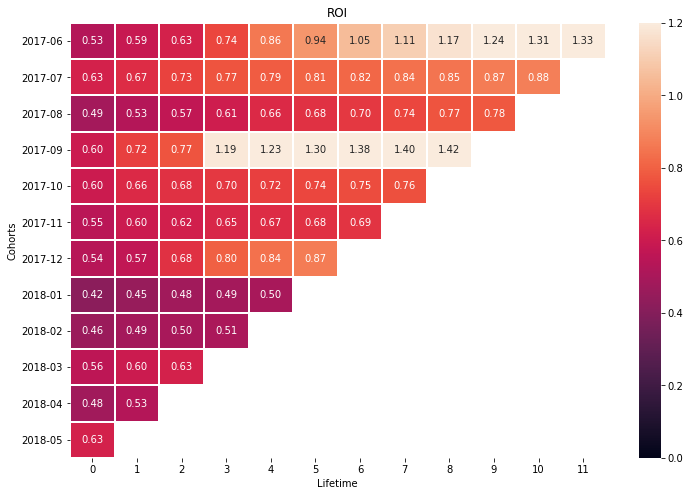

In [111]:
plt.figure(figsize=(12,8))
plt.title('ROI')
sns.heatmap(roi.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0, vmax=1.2)
plt.ylabel('Cohorts')
plt.xlabel('Lifetime');

К сожалению, инвестиции в различные рекламные источники пока не приносят прибыли. Только две из когорт - июнь 2017 и сентябрь 2017 прибыльны. И это две из трех когорт (кроме декабря 2017), где наблюдался самый высокий показатель среднего чека **Revenue per user**.   
Остальные когорты даже еще не вышли на уровень самоокупаемости.       
Но у всех когорт наблюдается положительная тенденция к увеличению **ROI**, так как это накопительный показатель 

In [112]:
roi[0].mean().round(2)

0.54

**ROI** пользователя за первый месяц lifetime составил 54%. Почти 50% расходов не окупаются 

In [113]:
roi.loc['2017-06':'2017-12', '0':'5'].sum().mean().round(2)

1.0

За полгода жизни когорт рекламные расходы полностью окупаются. Значит, начиная со следующего месяца, бизнес начинает приносить прибыль 

In [114]:
roi.loc['2017-06'].sum().round(2)

1.33

### Вывод      

Для рекламы своих услуг Яндекс.Афиша использует семь источников: 1-й, 2-й, 3-й, 4-й, 5-й, 9-й и 10-й. **Реклама услуг сервиса через 3-й источник наиболее затратная: 141300 руб за год и составляет 43% расходов.**      
На втором месте по затратам 4-й источник: 61000 рублей в год и 18,5% от всех расходов.      
**Самые дешевые рекламные источники 10-й и 9-й: на каждый из них приходится не более 6000 руб ежегодного бюджета**.
Остальные рекламные источники обходятся от 20000 до 60000 руб ежегодно.         

Если посмотреть на рекламные расходы за год с разбивкой по месяцам, то **самым затратным месяцем стал декабрь 2017г. - 38300 руб**. По-видимому это связано с новогодними каникулами: чем больше рекламы, тем больше клиентов решат пойти в кино или театр путем покупки билетов через Яндекс.Афишу.      
Самые дорогие в плане рекламного бюджета месяцы: с октября 2017 по март 2018: расходы на рекламу ежемесячно составляют более 30000 руб. Скорее всего, это вызвано сезонностью работы театров, концертных залов и тем, что пользователи в основном работают и свободное время тратят на культурно-массовые мероприятия. Весной интерес посетителей кино-концертных залов начинает переключаться на активный отдых, и расходы на рекламу тоже начинают снижаться.   
**Летом рекламный бюджет заметно снижается и не превышает 19000 руб в месяц.** Это объясняется тем, что многие уезжают за город или в отпуск. Вообщем пользователи гораздо меньше свободного времени летом проводят в кино или театрах.       

**В среднем расходы на привлечение одного пользователя когорты CAC составляют 9,15 рублей.**      
Самый большой CAC у пользователей когорты августа 2017г. - почти 11 рублей, самый маленький CAC у пользователей когорты мая 2018 г. - 7,5 рублей.           

К сожалению, **суммарные инвестиции в различные рекламные источники пока не приносят прибыли**. Только две из когорт - июнь 2017 и сентябрь 2017 прибыльны. И это две из трех когорт (кроме декабря 2017), где наблюдался самый высокий показатель среднего чека Revenue per user.Остальные когорты даже еще не вышли на уровень самоокупаемости.  
У всех когорт с течением времени **наблюдается положительная тенденция к увеличению ROI**.   
ROI пользователя за первый месяц lifetime составил 54%. Почти половина инвестиций не окупается. **За полгода жизни когорт рекламные расходы полностью окупаются. Значит, начиная со следующего месяца, бизнес начинает приносить прибыль.** ROI пользователя когорты июня 2017г. за год lifetime составляет почти 133%. Прибыль есть! 

### 3.4.  Посчитаем метрики в разрезе устройств и рекламных источников  <a name="abcdefj"></a>   
[*назад к оглавлению*](#0-bullet)    🚀

### 3.4.1. Рассчитаем LTV, CAC, ROI для устройств  <a name="abcdefji"></a>   
[*назад к оглавлению*](#0-bullet)    🚀

Посмотрим, как **ROI** отличается по разным устройствам: **desktop** и **touch**

###  LTV by desktop and touch 

In [115]:
revenue.head()

,device,source_id,uid,first_date,buy_ts,revenue,first_buy_date,time_before_buying
0,desktop,4,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:25:00,2.33,2018-03-09 20:25:00,20.0
1,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-09-04 12:46:00,2.44,2017-09-04 12:46:00,911.0
2,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-10-28 00:01:00,1.53,2017-09-04 12:46:00,911.0
3,desktop,5,16007536194108375387,2017-09-03 21:35:00,2017-10-28 19:16:00,1.53,2017-09-04 12:46:00,911.0
4,desktop,2,8056418121947262981,2017-06-04 14:17:00,2017-06-25 08:54:00,3.67,2017-06-25 08:54:00,29917.0


Рассчитаем **LTV** для устройств desktop и touch 

In [116]:
revenue['first_buy_month'] = revenue['first_buy_date'].astype('datetime64[M]')
revenue['buy_month'] = revenue['buy_ts'].astype('datetime64[M]')

In [117]:
desktop = revenue.query('device == "desktop"')
touch = revenue.query('device == "touch"')

Найдем количество новых покупателей в каждом месяце

In [118]:
buyers_d = desktop.groupby('first_buy_month').agg({'uid':'nunique'}).reset_index()
buyers_d.columns = ['first_buy_month', 'number_of_buyers']
buyers_t = touch.groupby('first_buy_month').agg({'uid':'nunique'}).reset_index()
buyers_t.columns = ['first_buy_month', 'number_of_buyers']

Посчитаем выручку за каждый месяц и добавим данные о новых покупателях

In [119]:
cohorts_d = desktop.groupby(['first_buy_month', 'buy_month']).agg({'revenue':'sum'}).reset_index()
cohorts_d = cohorts_d.merge(buyers_d, on='first_buy_month')
cohorts_t = touch.groupby(['first_buy_month', 'buy_month']).agg({'revenue':'sum'}).reset_index()
cohorts_t = cohorts_t.merge(buyers_t, on='first_buy_month')

Отобразим lifetime когорт

In [120]:
cohorts_d['first_buy_month'] = pd.to_datetime(cohorts_d['first_buy_month'])
cohorts_d['lifetime'] = ((cohorts_d['buy_month'] - cohorts_d['first_buy_month']) / np.timedelta64(1,'M')).round().astype('int')
cohorts_t['first_buy_month'] = pd.to_datetime(cohorts_t['first_buy_month'])
cohorts_t['lifetime'] = ((cohorts_t['buy_month'] - cohorts_t['first_buy_month']) / np.timedelta64(1,'M')).round().astype('int')

Построим сводные таблицы с показателем ltv за каждый месяц

In [121]:
cohorts_d['ltv'] = cohorts_d['revenue'] / cohorts_d['number_of_buyers']
ltv_d = cohorts_d.pivot_table(index='first_buy_month', columns='lifetime', values='ltv', aggfunc='mean').round(2)
ltv_d

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.89,0.52,0.50,1.12,1.17,0.87,1.12,0.69,0.65,0.69,0.67,0.26
2017-07-01,6.14,0.37,0.77,0.32,0.18,0.16,0.14,0.15,0.18,0.16,0.16,NaN
2017-08-01,5.26,0.55,0.52,0.45,0.59,0.29,0.23,0.47,0.35,0.21,NaN,NaN
2017-09-01,5.80,0.93,0.41,4.86,0.48,0.76,0.53,0.24,0.22,NaN,NaN,NaN
2017-10-01,5.13,0.56,0.21,0.18,0.16,0.14,0.10,0.13,NaN,NaN,NaN,NaN
2017-11-01,5.00,0.45,0.23,0.38,0.16,0.06,0.13,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.88,0.28,1.14,1.32,0.39,0.42,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.21,0.34,0.36,0.16,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.19,0.32,0.09,0.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
ltv_d.loc['2017-06':'2017-12', '0':'5'].sum().mean().round(2)

9.83

**LTV** пользователя, заходящего на сервис через desktop, за первые полгода жизни когорты составляет 9,8 рублей. Это немного больше, чем **LTV** пользователя в целом, без разбивки на мобильные устройства (9,3 рубля)

In [123]:
cohorts_t['ltv'] = cohorts_t['revenue'] / cohorts_t['number_of_buyers']
ltv_t = cohorts_t.pivot_table(index='first_buy_month', columns='lifetime', values='ltv', aggfunc='mean').round(2)
ltv_t

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,3.85,0.31,0.13,0.08,0.24,0.04,0.04,0.02,0.05,0.16,0.06,0.26
2017-07-01,5.51,0.21,0.06,0.49,0.17,0.14,0.06,0.13,0.07,0.10,0.12,NaN
2017-08-01,5.37,0.13,0.19,0.14,0.07,0.25,0.14,0.12,0.06,0.09,NaN,NaN
2017-09-01,5.04,1.87,0.94,0.51,0.08,0.19,1.40,0.27,0.05,NaN,NaN,NaN
2017-10-01,4.45,0.43,0.12,0.06,0.13,0.03,0.02,0.06,NaN,NaN,NaN,NaN
2017-11-01,5.85,0.19,0.06,0.09,0.08,0.03,0.03,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.17,0.17,0.07,0.06,0.01,0.03,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.85,0.11,0.08,0.07,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.05,0.15,0.04,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
ltv_t.loc['2017-06':'2017-12', '0':'5'].sum().mean().round(2)

7.01

**LTV** пользователя, заходящего на сервис через touch, за первые полгода жизни когорты составляет 7 рублей. Это меньше, чем **LTV** пользователя в целом, без разбивки на мобильные устройства (9,3 рубля)

###  CAC by desktop and touch 

Рассчитаем **CAC** на каждого пользователя desktop и touch

In [125]:
cohorts_t['device'] = "touch"
cohorts_d['device'] = "desktop"

In [126]:
cohorts_devices = cohorts_d.merge(cohorts_t, how='outer', on=['first_buy_month', 'buy_month', 'revenue', 'number_of_buyers', 'lifetime', 'ltv', 'device'])
cohorts_devices.head()

,first_buy_month,buy_month,revenue,number_of_buyers,lifetime,ltv,device
0,2017-06-01,2017-06-01,8321.37,1702,0,4.889172,desktop
1,2017-06-01,2017-07-01,882.43,1702,1,0.518467,desktop
2,2017-06-01,2017-08-01,844.70,1702,2,0.496298,desktop
3,2017-06-01,2017-09-01,1905.09,1702,3,1.119324,desktop
4,2017-06-01,2017-10-01,1992.87,1702,4,1.170899,desktop


Добавим данные об общем доходе за месяц и количестве пользователей

In [127]:
full_rev = revenue.groupby('first_buy_month').agg({'revenue':'sum', 'uid':'nunique'}).reset_index()
full_rev.columns = ['first_buy_month', 'full_revenue','full_buyers']
full_rev.head()

,first_buy_month,full_revenue,full_buyers
0,2017-06-01,24031.69,2023
1,2017-07-01,16127.92,1923
2,2017-08-01,11606.26,1370
3,2017-09-01,34676.32,2581
4,2017-10-01,27603.45,4340


In [128]:
roi_devices = cohorts_devices.merge(full_rev, on='first_buy_month')
roi_devices.head()

,first_buy_month,buy_month,revenue,number_of_buyers,lifetime,ltv,device,full_revenue,full_buyers
0,2017-06-01,2017-06-01,8321.37,1702,0,4.889172,desktop,24031.69,2023
1,2017-06-01,2017-07-01,882.43,1702,1,0.518467,desktop,24031.69,2023
2,2017-06-01,2017-08-01,844.70,1702,2,0.496298,desktop,24031.69,2023
3,2017-06-01,2017-09-01,1905.09,1702,3,1.119324,desktop,24031.69,2023
4,2017-06-01,2017-10-01,1992.87,1702,4,1.170899,desktop,24031.69,2023


Рассчитаем расходы на привлечение каждого пользователя

In [129]:
roi_devices = roi_devices.merge(monthly_costs, left_on='first_buy_month', right_on='costs_month')
roi_devices['cac'] = roi_devices['costs'] / roi_devices['full_buyers']
roi_devices.head()

,first_buy_month,buy_month,revenue,number_of_buyers,lifetime,ltv,device,full_revenue,full_buyers,costs,cac
0,2017-06-01,2017-06-01,8321.37,1702,0,4.889172,desktop,24031.69,2023,18015.0,8.905091
1,2017-06-01,2017-07-01,882.43,1702,1,0.518467,desktop,24031.69,2023,18015.0,8.905091
2,2017-06-01,2017-08-01,844.70,1702,2,0.496298,desktop,24031.69,2023,18015.0,8.905091
3,2017-06-01,2017-09-01,1905.09,1702,3,1.119324,desktop,24031.69,2023,18015.0,8.905091
4,2017-06-01,2017-10-01,1992.87,1702,4,1.170899,desktop,24031.69,2023,18015.0,8.905091


In [130]:
roi_devices.groupby('device').agg({'cac':'mean'}).round(2)

,cac
device,
desktop,9.32
touch,9.32


In [131]:
roi_devices.groupby('device').agg({'cac':'mean'})['cac'].mean().round(2)

9.32

Расходы на привлечение клиентов, использующих desktop или touch, **CAC** одинаковы и равны 9,3 рубля

###  ROI by desktop and touch 

Сравним **ROI** покупателя, использующего desktop и **ROI** покупателя, использующего touch. Посмотрим, как метрика изменяется во времени

In [132]:
roi_devices['roi'] = roi_devices['ltv'] / roi_devices['cac']
roi_devices['first_buy_month'] = roi_devices['first_buy_month'].dt.strftime('%Y-%m')
roi_d = roi_devices.query('device == "desktop"').pivot_table(index='first_buy_month', columns='lifetime', values='roi')
roi_d.cumsum(axis=1).round(2)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,0.55,0.61,0.66,0.79,0.92,1.02,1.14,1.22,1.29,1.37,1.45,1.47
2017-07,0.65,0.69,0.77,0.80,0.82,0.84,0.85,0.87,0.89,0.90,0.92,NaN
2017-08,0.49,0.54,0.59,0.63,0.68,0.71,0.73,0.77,0.81,0.83,NaN,NaN
2017-09,0.61,0.71,0.76,1.27,1.32,1.40,1.46,1.48,1.51,NaN,NaN,NaN
2017-10,0.61,0.68,0.70,0.73,0.74,0.76,0.77,0.79,NaN,NaN,NaN,NaN
2017-11,0.54,0.59,0.61,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12,0.56,0.59,0.72,0.87,0.92,0.96,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.42,0.46,0.49,0.51,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.47,0.50,0.51,0.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


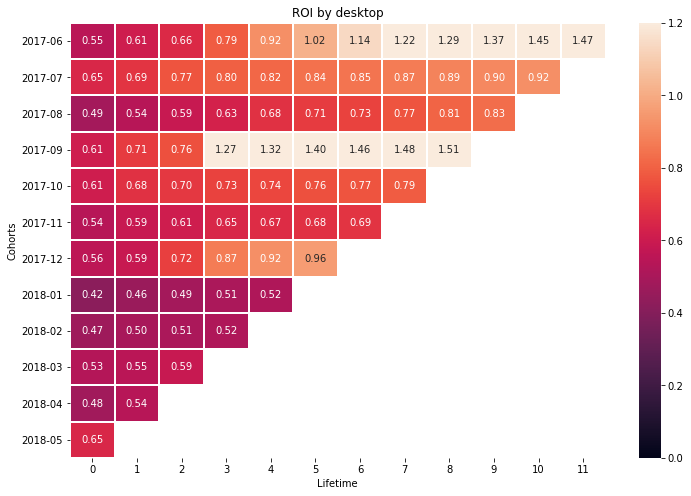

In [133]:
plt.figure(figsize=(12,8))
plt.title('ROI by desktop')
sns.heatmap(roi_d.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0, vmax=1.2)
plt.ylabel('Cohorts')
plt.xlabel('Lifetime');

In [134]:
roi_d.loc['2017-06':'2017-12', '0':'5'].sum().mean().round(2)

1.06

За полгода жизни когорт рекламные расходы полностью окупаются, **ROI** приносит 6% прибыли 

In [135]:
roi_d.loc['2017-06'].sum().round(2)

1.47

За год пользователи стационарных компьютеров desktop приносят 47,5% прибыли Яндекс.Афише 

In [136]:
roi_t = roi_devices.query('device == "touch"').pivot_table(index='first_buy_month', columns='lifetime', values='roi')
roi_t.cumsum(axis=1).round(2)

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06,0.43,0.47,0.48,0.49,0.52,0.52,0.53,0.53,0.53,0.55,0.56,0.59
2017-07,0.58,0.60,0.61,0.66,0.68,0.69,0.70,0.71,0.72,0.73,0.75,NaN
2017-08,0.50,0.51,0.53,0.54,0.55,0.57,0.58,0.59,0.60,0.61,NaN,NaN
2017-09,0.53,0.73,0.83,0.89,0.89,0.91,1.06,1.09,1.10,NaN,NaN,NaN
2017-10,0.53,0.58,0.60,0.60,0.62,0.62,0.63,0.63,NaN,NaN,NaN,NaN
2017-11,0.63,0.65,0.66,0.67,0.68,0.68,0.68,NaN,NaN,NaN,NaN,NaN
2017-12,0.48,0.50,0.50,0.51,0.51,0.52,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.39,0.40,0.41,0.41,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.45,0.47,0.47,0.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


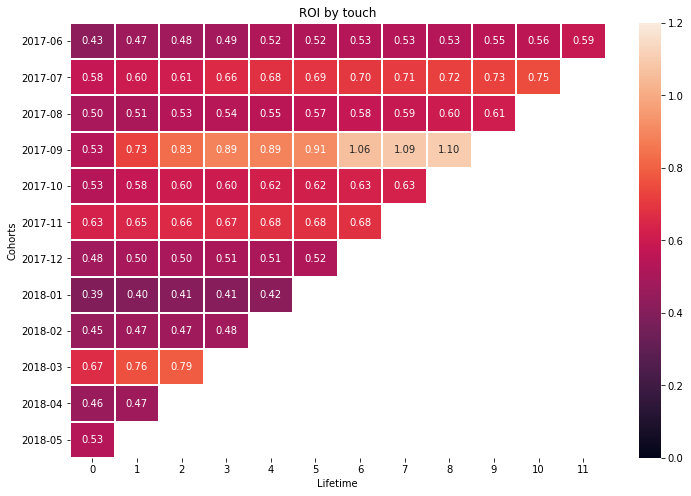

In [137]:
plt.figure(figsize=(12,8))
plt.title('ROI by touch')
sns.heatmap(roi_t.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='white', vmin=0, vmax=1.2)
plt.ylabel('Cohorts')
plt.xlabel('Lifetime');

In [138]:
roi_t.loc['2017-06':'2017-12', '0':'5'].sum().mean().round(2)

0.75

За полгода жизни когорт маркетинговый бюджет все еще убыточен. Расходы превышают доходы на 25% 

In [139]:
roi_t.loc['2017-09'].sum().round(2)

1.1

Единственная когорта, которая принесла прибыль в размере 10% сервису - это когорта пользователей touch сентября 2017г 

**ROI** пользователей desktop выше, чем **ROI** пользователей touch. У любителей desktop уже две когорты приносят Яндекс.Афише прибыль в течение полугода: это когорты июня и сентября 2017г. А приверженцы touch убыточны для сервиса. Единственные, кто начал окупаться в последние три месяца lifetime - это пользователи сентябрьской когорты 2017г  

### Вывод   

Проанализировали как изменяются бизнес показатели **LTV, CAC, ROI** в зависимости от того, с какого мобильного устройства покупатель заходил на сервис - **desktop** или **touch**.   
**LTV пользователя, заходящего на сервис через desktop, за первые полгода жизни когорты составляет 9,8 рублей**. Это немного больше, чем LTV пользователя в целом, без разбивки на мобильные устройства (9,3 рубля).         
**LTV пользователя, заходящегоо на сервис через touch, за первые полгода жизни когорты составляет 7 рублей**. Это меньше, чем LTV пользователя в целом, без разбивки на мобильные устройства.          

**Расходы на привлечение клиентов, использующих desktop или touch, CAC одинаковы и равны 9,3 рубля**.    

В результате более высокого **LTV** у пользователей desktop,  **ROI пользователей desktop выше, чем ROI пользователей touch**.    
    У любителей desktop две когорты приносят Яндекс.Афише прибыль уже с 4 - 6 месяца lifetime: это когорты июня и сентября 2017г. **За полгода жизни когорт пользователей desktop рекламные расходы полностью окупаются, ROI приносит 6% прибыли**. За год пользователи стационарных компьютеров desktop приносят 47,5% прибыли Яндекс.Афише. **За полгода жизни когорт пользователей touch маркетинговый бюджет все еще убыточен на 25%**. Единственная когорта, которая принесла прибыль в размере 10% сервису - это когорта пользователей touch сентября 2017г

### 3.4.2. Рассчитаем LTV, CAC, ROI для рекламных источников <a name="abcdefjik"></a>   
[*назад к оглавлению*](#0-bullet)    🚀

Проанализируем, как меняется **ROI** в зависимости от используемого сервисом рекламного источника 

###  LTV by source

In [140]:
revenue['source_id'].unique()

array([ 4,  5,  2,  3,  9,  1, 10,  7])

In [141]:
costs['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

Клиенты приходят из восьми источников, а рекламируются только семь. Источник под номером 7 не финансируется сервисом Яндекс.Афиша

Рассчитаем **LTV** для каждого рекламного источника

In [142]:
def find_ltv(df):
    buyers = df.groupby('first_buy_month').agg({'uid':'nunique'}).reset_index()
    buyers.columns = ['first_buy_month', 'number_of_buyers']
    cohorts = df.groupby(['first_buy_month', 'buy_month']).agg({'revenue':'sum'}).reset_index()
    cohorts = cohorts.merge(buyers, on='first_buy_month')
    cohorts['first_buy_month'] = pd.to_datetime(cohorts['first_buy_month'])
    cohorts['lifetime'] = ((cohorts['buy_month'] - cohorts['first_buy_month']) / np.timedelta64(1,'M')).round().astype('int')
    cohorts['ltv'] = cohorts['revenue'] / cohorts['number_of_buyers']
    ltv = cohorts.pivot_table(index='first_buy_month', columns='lifetime', values='ltv', aggfunc='mean').round(2)
    return cohorts, ltv

In [143]:
cohorts, ltv = find_ltv(revenue.query('source_id == 1'))
cohorts_1 = pd.DataFrame(cohorts)
ltv_1 = pd.DataFrame(ltv)
ltv_1

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,7.26,2.18,2.21,3.76,4.27,2.05,2.58,2.52,2.27,1.66,1.20,1.67
2017-07-01,7.29,1.10,5.35,1.51,0.88,0.90,0.45,0.65,0.86,0.99,0.93,NaN
2017-08-01,7.49,1.20,1.01,0.96,1.04,0.67,0.68,2.66,2.19,0.78,NaN,NaN
2017-09-01,6.01,1.80,0.56,0.92,0.04,0.10,0.08,0.31,0.59,NaN,NaN,NaN
2017-10-01,6.02,1.06,0.24,0.39,0.06,0.11,0.18,0.32,NaN,NaN,NaN,NaN
2017-11-01,7.39,0.57,0.96,0.89,0.16,0.11,0.08,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.58,0.31,0.29,0.25,0.03,0.10,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,5.77,0.09,0.14,0.97,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.69,1.00,0.07,0.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
cohorts, ltv = find_ltv(revenue.query('source_id == 2'))
cohorts_2 = pd.DataFrame(cohorts)
ltv_2 = pd.DataFrame(ltv)
ltv_2

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.44,0.49,0.27,1.92,1.67,0.92,1.60,1.48,1.34,0.73,1.36,0.43
2017-07-01,8.43,0.77,0.06,0.32,0.43,0.19,0.30,0.14,0.11,0.23,0.36,NaN
2017-08-01,5.74,0.94,0.18,0.25,0.52,0.06,0.12,0.39,0.03,0.08,NaN,NaN
2017-09-01,8.28,8.13,2.36,0.92,1.41,0.97,3.32,0.75,0.55,NaN,NaN,NaN
2017-10-01,7.68,2.46,0.66,0.54,0.56,0.27,0.10,0.25,NaN,NaN,NaN,NaN
2017-11-01,6.99,0.91,0.44,0.78,0.31,0.14,0.14,NaN,NaN,NaN,NaN,NaN
2017-12-01,8.81,1.54,9.33,11.10,3.05,3.21,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.34,1.09,1.74,0.24,0.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,5.42,0.65,0.32,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
cohorts, ltv = find_ltv(revenue.query('source_id == 3'))
cohorts_3 = pd.DataFrame(cohorts)
ltv_3 = pd.DataFrame(ltv)
ltv_3

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.40,0.11,0.19,0.31,0.19,0.19,0.13,0.03,0.05,0.05,0.03,0.03
2017-07-01,6.11,0.26,0.12,0.39,0.04,0.07,0.04,0.13,0.08,0.04,0.06,NaN
2017-08-01,5.08,0.15,0.29,0.11,0.16,0.05,0.06,0.09,0.08,0.06,NaN,NaN
2017-09-01,5.56,0.25,0.32,0.09,0.22,0.12,0.13,0.07,0.12,NaN,NaN,NaN
2017-10-01,4.79,0.46,0.12,0.06,0.11,0.10,0.02,0.07,NaN,NaN,NaN,NaN
2017-11-01,4.53,0.13,0.08,0.12,0.06,0.03,0.03,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.18,0.13,0.14,0.13,0.10,0.06,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.11,0.18,0.13,0.08,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.79,0.31,0.09,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
cohorts, ltv = find_ltv(revenue.query('source_id == 4'))
cohorts_4 = pd.DataFrame(cohorts)
ltv_4 = pd.DataFrame(ltv)
ltv_4

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.75,0.04,0.17,0.46,1.15,1.49,1.43,0.23,0.22,0.80,1.27,0.08
2017-07-01,5.54,0.06,0.08,0.16,0.06,0.06,0.10,0.05,0.09,0.06,0.02,NaN
2017-08-01,5.06,0.17,0.13,0.27,0.15,0.21,0.08,0.19,0.09,0.12,NaN,NaN
2017-09-01,4.77,0.48,0.31,0.29,0.05,0.24,1.25,0.27,0.05,NaN,NaN,NaN
2017-10-01,4.37,0.15,0.15,0.11,0.12,0.09,0.09,0.06,NaN,NaN,NaN,NaN
2017-11-01,5.14,0.65,0.10,0.41,0.19,0.04,0.22,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.17,0.09,0.09,0.09,0.04,0.09,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.78,0.12,0.08,0.07,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.09,0.11,0.04,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
cohorts, ltv = find_ltv(revenue.query('source_id == 5'))
cohorts_5 = pd.DataFrame(cohorts)
ltv_5 = pd.DataFrame(ltv)
ltv_5

lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_buy_month,,,,,,,,,,,,
2017-06-01,4.95,0.90,0.45,0.87,0.66,0.30,0.91,0.59,0.56,0.95,0.16,0.12
2017-07-01,5.29,0.32,0.45,0.15,0.10,0.11,0.03,0.11,0.09,0.06,0.07,NaN
2017-08-01,5.05,0.75,0.83,0.71,1.08,0.59,0.39,0.25,0.24,0.23,NaN,NaN
2017-09-01,6.20,0.18,0.33,16.17,0.77,2.02,0.28,0.20,0.02,NaN,NaN,NaN
2017-10-01,5.09,0.22,0.12,0.12,0.11,0.10,0.14,0.13,NaN,NaN,NaN,NaN
2017-11-01,4.56,0.19,0.12,0.06,0.14,0.04,0.11,NaN,NaN,NaN,NaN,NaN
2017-12-01,5.01,0.14,0.09,0.05,0.02,0.01,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.35,0.52,0.38,0.03,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.32,0.09,0.05,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
cohorts, ltv = find_ltv(revenue.query('source_id == 7'))
cohorts_7 = pd.DataFrame(cohorts)
ltv_7 = pd.DataFrame(ltv)
ltv_7

lifetime,0
first_buy_month,
2017-08-01,1.22


7-ой рекламный источник никак не финансируется сервисом Яндекс.Афиша. Так как расходы на маркетинг нулевые, **ROI** для этого источника тоже отсутствует

In [149]:
cohorts, ltv = find_ltv(revenue.query('source_id == 9'))
cohorts_9 = pd.DataFrame(cohorts)
ltv_9 = pd.DataFrame(ltv)
ltv_9

lifetime,0,1,2,3,4,5,6,7,8,9,10
first_buy_month,,,,,,,,,,,
2017-06-01,3.57,0.07,0.59,0.61,0.27,0.44,0.53,0.12,0.54,0.12,0.08
2017-07-01,4.47,0.16,0.63,0.49,0.37,0.06,0.29,0.06,0.43,0.02,0.07
2017-08-01,4.07,0.20,0.64,0.23,0.05,0.07,0.14,0.29,0.08,0.15,NaN
2017-09-01,4.30,1.02,0.63,0.80,0.60,0.13,0.62,0.67,0.91,NaN,NaN
2017-10-01,5.06,0.54,0.44,0.12,0.29,0.54,0.02,0.02,NaN,NaN,NaN
2017-11-01,3.74,0.13,0.16,0.29,0.15,0.03,0.02,NaN,NaN,NaN,NaN
2017-12-01,3.83,0.31,0.17,0.27,0.02,0.15,NaN,NaN,NaN,NaN,NaN
2018-01-01,2.83,0.22,0.20,0.04,0.02,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.80,0.17,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
cohorts, ltv = find_ltv(revenue.query('source_id == 10'))
cohorts_10 = pd.DataFrame(cohorts)
ltv_10 = pd.DataFrame(ltv)
ltv_10

lifetime,0,1,2,3,4,5,6,7,8,9
first_buy_month,,,,,,,,,,
2017-06-01,2.41,0.12,NaN,NaN,NaN,NaN,NaN,NaN,0.01,NaN
2017-07-01,3.46,0.03,NaN,0.15,NaN,NaN,NaN,NaN,0.01,NaN
2017-08-01,5.00,0.11,0.33,NaN,NaN,NaN,NaN,0.12,NaN,0.09
2017-09-01,2.23,0.06,0.08,0.19,0.03,NaN,NaN,0.01,0.02,NaN
2017-10-01,2.62,0.08,0.01,0.02,0.04,0.01,0.02,0.05,NaN,NaN
2017-11-01,4.62,0.05,0.01,0.19,0.10,0.05,0.05,NaN,NaN,NaN
2017-12-01,3.79,0.14,NaN,NaN,NaN,0.06,NaN,NaN,NaN,NaN
2018-01-01,3.10,0.02,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,2.47,0.12,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим сколько приносит денег пользователь за полгода, привлекаемый из разных рекламных источников

In [151]:
def avg_ltv(df):
    return df.loc['2017-06':'2017-12', '0':'5'].sum().mean().round(2)

In [152]:
avg_ltv(ltv_1)

14.01

In [153]:
avg_ltv(ltv_2)

18.08

In [154]:
avg_ltv(ltv_3)

6.69

In [155]:
avg_ltv(ltv_4)

7.04

In [156]:
avg_ltv(ltv_5)

10.9

In [157]:
avg_ltv(ltv_9)

6.78

In [158]:
avg_ltv(ltv_10)

4.33

Самые доходные клиенты приходят из 2, 1 и 5 рекламных источников. 10-й рекламный источник приносит наименее доходных клиентов

###  CAC by source 


Рассчитаем **CAC** на каждого пользователя из разных рекламных источников

In [159]:
cohorts_1['source_id'] = 1
cohorts_2['source_id'] = 2
cohorts_3['source_id'] = 3
cohorts_4['source_id'] = 4
cohorts_5['source_id'] = 5
cohorts_9['source_id'] = 9
cohorts_10['source_id'] = 10

In [160]:
cohorts_sources = cohorts_1.merge(cohorts_2, how='outer', on=['first_buy_month', 'buy_month', 'revenue', 'number_of_buyers', 'lifetime', 'ltv', 'source_id']).\
merge(cohorts_3, how='outer', on=['first_buy_month', 'buy_month', 'revenue', 'number_of_buyers', 'lifetime', 'ltv', 'source_id']).\
merge(cohorts_4, how='outer', on=['first_buy_month', 'buy_month', 'revenue', 'number_of_buyers', 'lifetime', 'ltv', 'source_id']).\
merge(cohorts_5, how='outer', on=['first_buy_month', 'buy_month', 'revenue', 'number_of_buyers', 'lifetime', 'ltv', 'source_id']).\
merge(cohorts_9, how='outer', on=['first_buy_month', 'buy_month', 'revenue', 'number_of_buyers', 'lifetime', 'ltv', 'source_id']).\
merge(cohorts_10, how='outer', on=['first_buy_month', 'buy_month', 'revenue', 'number_of_buyers', 'lifetime', 'ltv', 'source_id'])
cohorts_sources.head()

,first_buy_month,buy_month,revenue,number_of_buyers,lifetime,ltv,source_id
0,2017-06-01,2017-06-01,1378.70,190,0,7.256316,1
1,2017-06-01,2017-07-01,414.98,190,1,2.184105,1
2,2017-06-01,2017-08-01,419.43,190,2,2.207526,1
3,2017-06-01,2017-09-01,714.24,190,3,3.759158,1
4,2017-06-01,2017-10-01,811.20,190,4,4.269474,1


Добавим данные о количестве пользователей и расходах за месяц по каждому рекламному источнику 

In [161]:
costs_by_sources = costs.groupby(['costs_month', 'source_id']).agg({'costs':'sum'}).reset_index()

In [162]:
roi_sources = cohorts_sources.merge(costs_by_sources, how='left', left_on=['first_buy_month', 'source_id'], right_on=['costs_month', 'source_id'])
roi_sources['cac'] = roi_sources['costs'] / roi_sources['number_of_buyers']
roi_sources.head()

,first_buy_month,buy_month,revenue,number_of_buyers,lifetime,ltv,source_id,costs_month,costs,cac
0,2017-06-01,2017-06-01,1378.70,190,0,7.256316,1,2017-06-01,1125.61,5.924263
1,2017-06-01,2017-07-01,414.98,190,1,2.184105,1,2017-06-01,1125.61,5.924263
2,2017-06-01,2017-08-01,419.43,190,2,2.207526,1,2017-06-01,1125.61,5.924263
3,2017-06-01,2017-09-01,714.24,190,3,3.759158,1,2017-06-01,1125.61,5.924263
4,2017-06-01,2017-10-01,811.20,190,4,4.269474,1,2017-06-01,1125.61,5.924263


Рассчитаем расходы на привлечение одного пользователя по каждому рекламному источнику 

In [163]:
roi_sources.groupby('source_id').agg({'cac':'mean'}).round(2).sort_values(by='cac', ascending=False)

,cac
source_id,
3,14.06
2,12.64
5,7.17
1,7.15
4,6.98
9,5.06
10,5.04


In [164]:
roi_sources.groupby('source_id').agg({'cac':'mean'})['cac'].mean().round(2)

8.3

Расходы на привлечение пользователей из разных рекламных источников сильно отличаются: дороже всего обходятся клиенты из 3-го и 2-го источников - **CAC** 14 и 12,5 рублей, дешевле всего - клиенты из 10-го и 9-го источников, **CAC** 5 рублей. Средний показатель **CAC** составляет 8,3 рубля 

### ROI by source 

Сравним **ROI** покупателей из разных рекламных источников. Посмотрим, как метрика изменяется во времени

In [165]:
roi_sources['roi'] = roi_sources['ltv'] / roi_sources['cac']
roi_sources['first_buy_month'] = roi_sources['first_buy_month'].dt.strftime('%Y-%m')

In [166]:
def show_roi(df):
    roi = df.pivot_table(index='first_buy_month', columns='lifetime', values='roi')
    plt.figure(figsize=(12,8))
    plt.title('ROI by source')
    heatmap = sns.heatmap(roi.cumsum(axis=1).round(2), annot=True,fmt='.2f', linewidths=1, linecolor='white', vmin=0, vmax=1.5)
    plt.ylabel('Cohorts')
    plt.xlabel('Lifetime')
    return heatmap

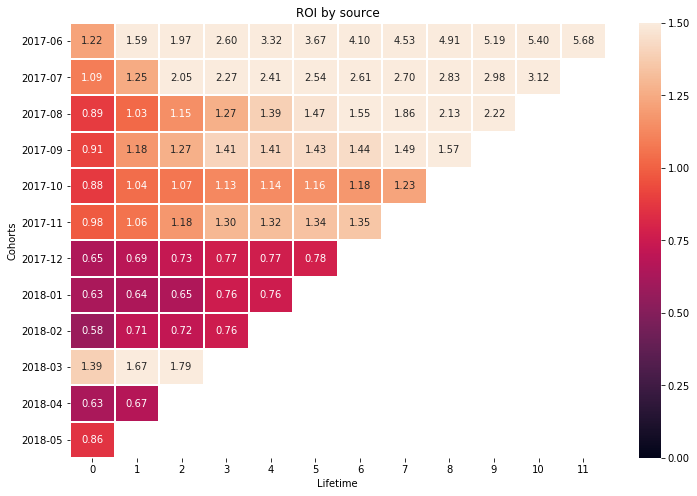

In [167]:
roi_1 = show_roi(roi_sources.query('source_id == 1'))

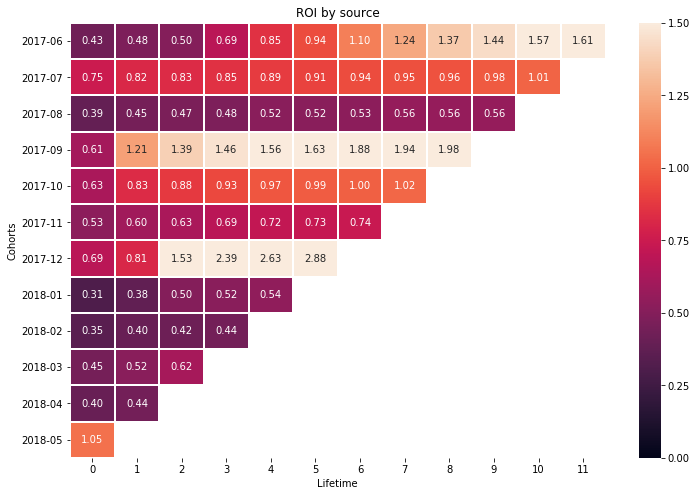

In [168]:
roi_2 = show_roi(roi_sources.query('source_id == 2'))

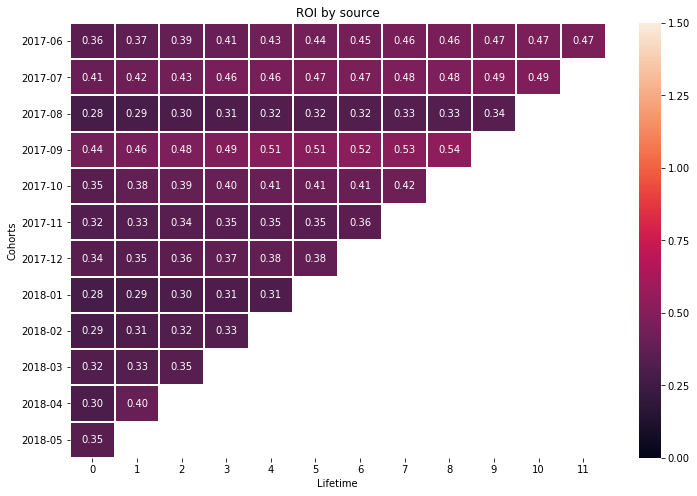

In [169]:
roi_3 = show_roi(roi_sources.query('source_id == 3'))

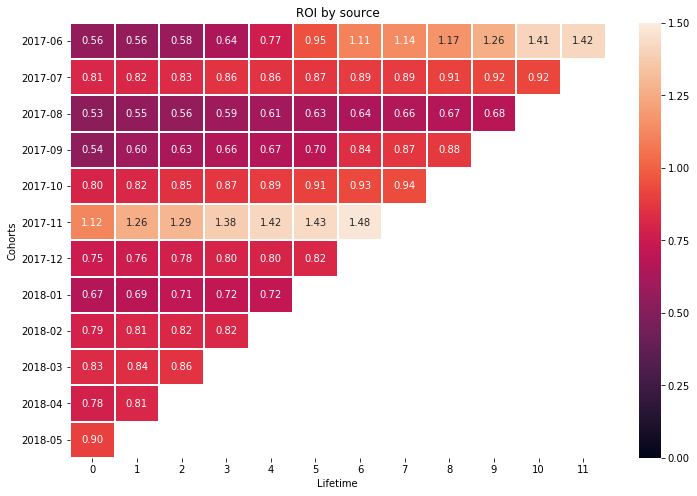

In [170]:
roi_4 = show_roi(roi_sources.query('source_id == 4'))

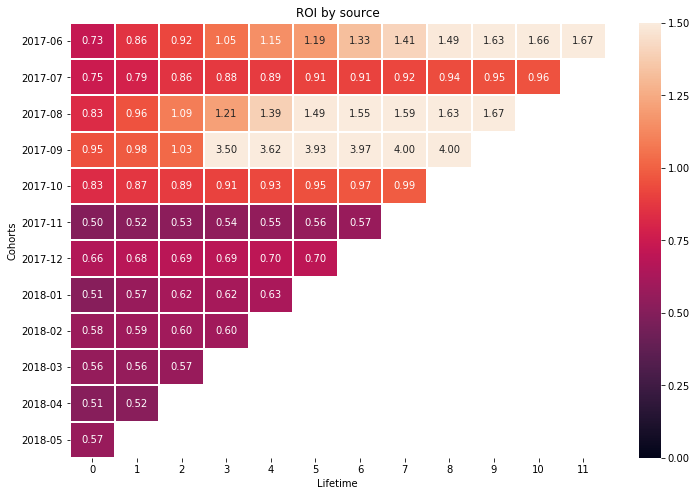

In [171]:
roi_5 = show_roi(roi_sources.query('source_id == 5'))

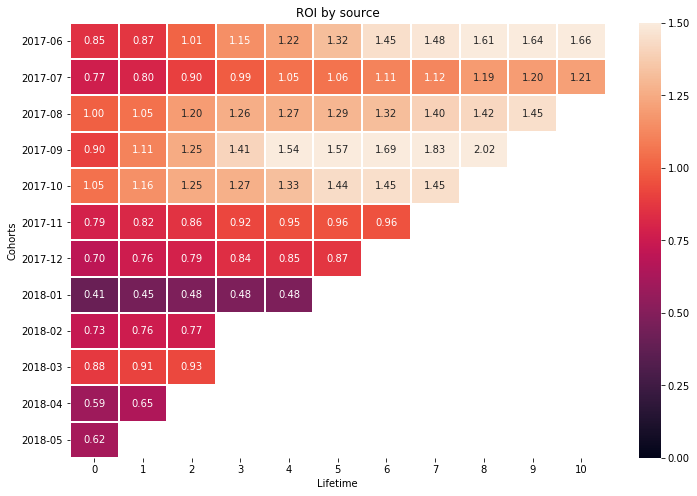

In [172]:
roi_9 = show_roi(roi_sources.query('source_id == 9'))

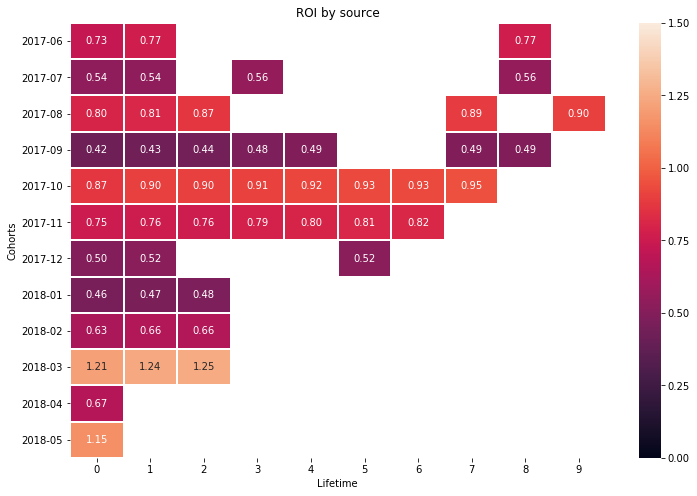

In [173]:
roi_10 = show_roi(roi_sources.query('source_id == 10'))

На тепловых картах распределения **ROI** в течение lifetime когорт видно, что рекламные затраты Яндекс.Афиши хорошо окупаются через 1-й, 2-й, 9-й и 5-й рекламные источники. Клиенты уже на второй месяц пользования сервисом (а кто-то и на первый) начинают приносить прибыль сервису.      
Остальные рекламные источники: 4-й и 10-й тоже привлекают платежеспособных клиентов, но не так много, как хотелось бы.    
А вот расходы на рекламу через 3-й источник надо приостановить, так как его клиенты не приносят прибыли сервису ни в настоящее время, ни планируют в будущем 

Найдем, чему равен показатель **ROI** за полгода жизни когорт, привлеченных из разных рекламных источников 

In [174]:
def avg_roi(source):
    avg_roi = roi_sources.loc[roi_sources['source_id'] == source].\
    pivot_table(index='first_buy_month', columns='lifetime', values='roi').\
    loc['2017-06':'2017-12', '0':'5'].sum().mean().round(2)
    return avg_roi

In [175]:
avg_roi(1)

2.06

In [176]:
avg_roi(2)

1.43

In [177]:
avg_roi(3)

0.48

In [178]:
avg_roi(4)

1.05

In [179]:
avg_roi(5)

1.62

In [180]:
avg_roi(9)

1.42

In [181]:
avg_roi(10)

0.82

Пользователи, привлеченные 1-м рекламным источником, через полгода дают 100% прибыли! 62% прибыли за тот же период приносят пользователи из 5-го рекламного источника. 9-й и 2-й рекламные источники тоже показывают прибыль в 40%. 4-й рекламный источник за полгода только выходит на самоокупаемость.       
10-й и 3-й рекламные источники убыточны. Аутсайдер - 3-й рекламный источник. За полгода расходы не окупились даже на половину 

### 4. Вывод <a name="abcdefjikl"></a>   
[*назад к оглавлению*](#0-bullet)    🚀

Для сервиса Яндекс.Афиша необходимо было оптимизировать маркетинговые затраты. Для этого нам надо выяснить, как люди пользуются продуктом сервиса, когда они начинают покупать, сколько денег приносит каждый клиент, когда клиент окупается.    
В нашем распоряжении были данные с июня 2017 по конец мая 208 года:      
лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за этот период, статистика рекламных расходов.   
Обнаруженные в ходе обработки данных несоответствия устранены:   
- названия cтолбцов приведены к единому формату   
- столбцы с датами приведены к типу datetime.   

**Рассчитаны показатели пользовательской активности:**   
- за день **DAU** - 907 человек   
- за неделю **WAU** - 5716 человек  
- за месяц **MAU** - 23228 человек.     

В среднем за день на Яндекс.Афише открывается 987 сессий. На одного пользователя ежедневно приходится одна сессия.   
Средняя продолжительность пользовательской сессии **ASL в Яндекс.Афише составляет 1 минуту.**   

При расчете **Retention Rate** обнаружилось, что уже на следующем месяце использования сервиса количество пользователей снижается до 5-8%. В дальнейшем  **ежемесячно возвращаются на сервис 2-3% пользователей** из каждой когорты. Пользователи самой первой когорты (июнь 2017 г.) наиболее преданные клиенты Яндекс.Афиши по сравнению с пользователями других когорт. У пользователей когорт 2018 г. падение пользовательской активности до 2% наблюдается уже на 2-4 месяц lifetime.         

**Средний чек Revenue per user пользователя Яндекс.Афиши составляет 6 рублей**. Величина среднего чека у разных когорт разная.   
Лидеры - когорты 2017 года: сентябрь - 11 рублей и июнь - 9 рублей.   
Аутсайдеры - когорты 2018 года: июнь и февраль. Средний чек не превышает 4,5 рублей. Сентябрьская когорта на 4-й месяц жизни установила рекорд по максимуму, средний чек составил 139 руб.    
Наблюдается общая тенденция роста среднего чека со второго месяца жизни когорты вплоть до четвертого месяца. Вероятно сервис Яндекс.Афиши предлагает своим постоянным клиентам какие-то преференции или бонусы, и пользователи этим с удовольствием пользуются.         

Исходя из описания статистических показателей **50% пользователей Яндекс.Афиши совершает свою первую покупку в течение 22 минут после регистрации, в том числе 25% пользователей совершают свою первую покупку в течение 4 минут после регистрации, в том числе 8% пользователей сразу после регистрации оплачивают покупку.** У еще 25% пользователей это время занимает чуть больше 4-х суток. По-видимому, пользователи, с момента регистрации которых и до первой покупки проходит несколько часов, дней, а иногда и месяцев, после регистрации на сервисе меняют свое решение пойти в кино или театр. А по прошествии какого-то времени приобретают билеты на Яндекс.Афише, используя уже имеющиеся логин и пароль.     
    
**Среднее количество покупок, совершаемых пользователем в течение полугода - 11 покупок.** Количество покупок, совершенных одним пользователем в разных когортах в течение полугода - от 18 до 8.   
В первый месяц существования каждой когорты пользователи совершают максимальное количество покупок **Number of purchases** - от 1533 до 5052. Количество покупок, совершаемых пользователями ежемесячно, в среднем составляет **372 покупки** Среднее количество покупок, совершаемых пользователями ежемесячно, за первые полгода жизни когорты, почти в два раза больше - **700 покупок**. Такое увеличение объясняется тем, что первый месяц жизни когорты является месяцем максимальной покупательской активности пользователей. С течением свремени происходит затухание величины среднего количества покупок. С течением времени наблюдается угасание пользовательской активности. Наиболее активной в течение всей жизни остается когорта покупателей июня 2017г.            

В результате расчета **LTV** выяснилось, что больше всего денег пользователи приносят в первый месяц lifetime когорты. По доходности тройку лидеров занимают уже знакомые нам по Revenue per user когорты: июнь, сентябрь и декабрь 2017г. **LTV пользователя за первые полгода жизни когорты составляет 9,3 рубля**. LTV пользователя когорты июня 2017г. за год составляет почти 12 рублей. С течением времени происходит затухание показателя LTV в месяц, хотя в общем LTV растет, т.к. это накопительная величина.   
 
Для рекламы своих услуг Яндекс.Афиша использует семь источников: 1-й, 2-й, 3-й, 4-й, 5-й, 9-й и 10-й. **Реклама услуг сервиса через 3-й источник наиболее затратная: 141300 руб за год и составляет 43% расходов.**         
На втором месте по затратам 4-й источник: 61000 рублей в год и 18,5% от всех расходов.         
Самые дешевые рекламные источники 10-й и 9-й: на каждый из них приходится не более 6000 руб ежегодного бюджета.
Остальные рекламные источники обходятся от 20000 до 60000 руб ежегодно.            

Если посмотреть на рекламные расходы за год с разбивкой по месяцам, то **самым затратным месяцем стал декабрь 2017г. - 38300 руб**. По-видимому это связано с новогодними каникулами: чем больше рекламы, тем больше клиентов решат пойти в кино или театр путем покупки билетов через Яндекс.Афишу.         
Самые дорогие в плане рекламного бюджета месяцы: с октября 2017 по март 2018: расходы на рекламу ежемесячно составляют более 30000 руб. Скорее всего, это вызвано сезонностью работы театров, концертных залов и тем, что пользователи в основном работают и свободное время тратят на культурно-массовые мероприятия. Весной интерес посетителей кино-концертных залов начинает переключаться на активный отдых, и расходы на рекламу тоже начинают снижаться.      
**Летом рекламный бюджет заметно снижается и не превышает 19000 руб в месяц.** Это объясняется тем, что многие уезжают за город или в отпуск. Вообщем пользователи гораздо меньше свободного времени летом проводят в кино или театрах.       

В среднем расходы на привлечение одного пользователя когорты **CAC составляют 9,15 рублей.**         
Самый большой CAC у пользователей когорты августа 2017г. - почти 11 рублей, самый маленький CAC у пользователей когорты мая 2018 г. - 7,5 рублей.              

К сожалению, суммарные инвестиции в различные рекламные источники пока не приносят прибыли. Только две из когорт - июнь 2017 и сентябрь 2017 прибыльны. Остальные когорты даже еще не вышли на уровень самоокупаемости.  
У всех когорт с течением времени наблюдается положительная тенденция к увеличению ROI, т.к. это тоже накопительный показатель.      

ROI пользователя за первый месяц lifetime составил 54%. Почти половина инвестиций не окупаются. **За полгода жизни когорт рекламные расходы полностью окупаются. Значит, уже со следующего месяца бизнес начинает приносить прибыль.** ROI пользователя когорты июня 2017г. за год lifetime уже составляет почти 133%.       

Проанализировали как изменяются бизнес показатели LTV, CAC, ROI в зависимости от того, с какого мобильного устройства покупатель заходил на сервис - desktop или touch.      
LTV пользователя, заходящего на сервис через desktop, за первые полгода жизни когорты составляет 9,8 рублей. Это немного больше, чем LTV пользователя в целом, без разбивки на мобильные устройства (9,3 рубля).            
LTV пользователя, заходящегоо на сервис через touch, за первые полгода жизни когорты составляет 7 рублей. Это меньше, чем LTV пользователя в целом, без разбивки на мобильные устройства.             

Расходы на привлечение клиентов, использующих desktop или touch, CAC одинаковы и равны 9,3 рубля.       

В результате более высокого LTV у пользователей desktop,  ROI пользователей desktop выше, чем ROI пользователей touch.       
    У любителей desktop две когорты приносят Яндекс.Афише прибыль уже с 4 - 6 месяца lifetime: это когорты июня и сентября 2017г. **За полгода жизни когорт пользователей desktop рекламные расходы полностью окупаются, ROI приносит 6% прибыли**. За год пользователи стационарных компьютеров desktop приносят 47,5% прибыли Яндекс.Афише. **За полгода жизни когорт пользователей touch маркетинговый бюджет все еще убыточен на 25%**. Единственная когорта, которая принесла прибыль в размере 10% сервису - это когорта пользователей touch сентября 2017г.      
    
Проанализировали как изменяются бизнес показатели LTV, CAC, ROI в зависимости от того, из какого рекламного источника был привлечен клиент на Яндекс.Афишу.      
Самые прибыльные клиенты приходят из 2-го, 1-го и 5-го рекламных источников: LTV клиента за полгода пользования сервисом составляет 18 рублей, 14 рублей и 11 рублей соответствено. 10-й рекламный источник приносит наименее доходных клиентов: LTV 4,3 рубля.         

Расходы на привлечение пользователей из разных рекламных источников сильно отличаются: дороже всего обходятся клиенты из 3-го и 2-го источников - CAC 14 и 12,5 рублей, дешевле всего - клиенты из 10-го и 9-го источников, CAC 5 рублей. Средний показатель CAC составляет 8,3 рубля.    

На тепловых картах распределения **ROI** в течение lifetime когорт видно, что рекламные затраты Яндекс.Афиши хорошо окупаются через 1-й, 2-й, 9-й и 5-й рекламные источники. Клиенты уже на второй месяц пользования сервисом (а кто-то и на первый) начинают приносить прибыль сервису.      
Остальные рекламные источники: 4-й и 10-й тоже привлекают платежеспособных клиентов, но не так много, как хотелось бы.    
А вот расходы на рекламу через 3-й источник надо приостановить, так как его клиенты не приносят прибыли сервису ни в настоящее время, ни планируют в будущем.    
    Пользователи, привлеченные 1-м рекламным источником, через полгода дают 100% прибыли! 62% прибыли за тот же период приносят пользователи из 5-го рекламного источника. 9-й и 2-й рекламные источники тоже показывают прибыль в 40%. 4-й рекламный источник за полгода только выходит на самоокупаемость.
10-й и 3-й рекламные источники убыточны. Аутсайдер - 3-й рекламный источник. За полгода расходы не окупились даже на половину.

***В результате анализа бизнес показателей можно сделать выводы, что сервису Яндекс.Афиша следует ориентироваться на пользователей, заходящих на сервис через стационарные компьютеры, desktop.***    

***Маркетинговый бюджет стоит перераспределить в пользу 1-го и 5-го рекламных источников. Ресурсы можно взять из средств, направляемых на 3-й, 4-й  и 10-й источники. Расходы на рекламу через 3-й источник следует приостановить.*** 